In [1]:
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import scipy.io
import itertools
from skimage import io, filters, morphology, restoration, feature, transform
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from itertools import cycle
import sklearn.cluster
from sklearn.preprocessing import MinMaxScaler

import numpy as np

import nglpy_cuda as nglpy
import topopy
import pdir
import time
import os
import utpy

## Reusable Functions

In [2]:
def show_image(image):
    plt.figure(num=None, dpi=200)
    img = plt.imshow(image, cmap=plt.cm.Greys, norm=colors.LogNorm(vmin=image.min(), vmax=image.max()),)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.colorbar(img)

In [3]:
def massage_data(grid):
    X = []
    Y = []
    for row, vals  in enumerate(grid):
        for col, val in enumerate(vals):
            X.append([col, row])
            Y.append(val)
    return np.array(X, dtype=np.float64), np.array(Y, dtype=np.float64)

In [4]:
def alpha_blend(src, dest):
    out_image = np.zeros(dest.shape)
    out_image[:, :, 3] = src[:, :, 3] + dest[:, :, 3]*(1 - src[:, :, 3])
    out_image[:, :, :-1] = src[:,:,:-1]*src[:,:3] + dest[:,:,:-1]*dest[:,:,3]*(1 - src[:, :, 3])
    out_image[:, :, :-1] /= out_image[:, :, 3]
    
def overlay_alpha_image_lazy(background_rgb, overlay_rgba, alpha):
    # cf https://en.wikipedia.org/wiki/Alpha_compositing#Alpha_blending
    # If the destination background is opaque, then
    #   out_rgb = overlay_rgb * overlay_alpha + background_rgb * (1 - overlay_alpha)
    overlay_alpha = overlay_rgba[: , : , 3].astype(np.float) / 255. * alpha
    overlay_alpha_3 = np.dstack((overlay_alpha, overlay_alpha, overlay_alpha))
    overlay_rgb = overlay_rgba[: , : , : 3].astype(np.float)
    background_rgb_f = background_rgb.astype(np.float)
    out_rgb = overlay_rgb * overlay_alpha_3 + background_rgb_f * (1. - overlay_alpha_3)
    out_rgb = out_rgb.astype(np.uint8)
    return out_rgb

def overlay_alpha_image_precise(background_rgb, overlay_rgba, alpha, gamma_factor=2.2):
    """
    cf minute physics brilliant clip "Computer color is broken" : https://www.youtube.com/watch?v=LKnqECcg6Gw
    the RGB values are gamma-corrected by the sensor (in order to keep accuracy for lower luminancy),
    we need to undo this before averaging.
    """
    overlay_alpha = overlay_rgba[: , : , 3].astype(np.float) / 255. * alpha
    overlay_alpha_3 = np.dstack((overlay_alpha, overlay_alpha, overlay_alpha))

    overlay_rgb_squared = np.float_power(overlay_rgba[: , : , : 3].astype(np.float), gamma_factor)
    background_rgb_squared = np.float_power( background_rgb.astype(np.float), gamma_factor)
    out_rgb_squared = overlay_rgb_squared * overlay_alpha_3 + background_rgb_squared * (1. - overlay_alpha_3)
    out_rgb = np.float_power(out_rgb_squared, 1. / gamma_factor)
    out_rgb = out_rgb.astype(np.uint8)
    return out_rgb


In [5]:
def plot_realization(grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    graph = nglpy.EmptyRegionGraph(max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')
    tmc.build(X, Y)

    partitions = tmc.get_partitions(0.1)
    keys = partitions.keys()

    keyMap = {}
    for i,k in enumerate(keys):
        keyMap[k] = i

    colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]
    
    ccycle = cycle(colorList)

    uniqueCount = len(keys)
    usedColors = []
    for i,c in zip(range(uniqueCount), ccycle):
        usedColors.append(c)
    cmap = colors.ListedColormap(usedColors)
    bounds = np.array([keyMap[k] for k in keys]) - 0.5
    bounds = bounds.tolist()
    bounds.append(bounds[-1]+1)
    plt.figure(dpi=800)

    color_mesh = np.zeros((w, h))
    for key, indices in partitions.items():
        for idx in indices:
            color_mesh[idx // w, idx % w] = keyMap[key]

    img = plt.imshow(color_mesh, cmap=cmap, interpolation="nearest", origin="lower")
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.colorbar(img, cmap=cmap, ticks=[range(uniqueCount)], boundaries=bounds)
    plt.contour(grid, cmap=cm.Greys)

In [6]:
def count_persistence(grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    graph = nglpy.EmptyRegionGraph(max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')
    tmc.build(X, Y)

    partitions = tmc.get_partitions()
    sorted_hierarchy = sorted([(p, k, x) for k, (p, x, s) in tmc.merge_sequence.items()])
    
    field = np.zeros(Y.shape, dtype=int)
    for k, v in partitions.items():
        field[v] = k
    
    counts = np.zeros(Y.shape)
    weighted_counts = np.zeros(Y.shape)
    last_persistence = 0
    for persistence, dying_index, surviving_index in sorted_hierarchy:
        next_field = np.array(field)
        next_field[np.where(next_field == dying_index)] = surviving_index
        
        counts[np.where(field == next_field)] += 1
        weighted_counts[np.where(field == next_field)] += (persistence-last_persistence)
        field = next_field
        last_persistence = persistence

    return counts.reshape(grid.shape), weighted_counts.reshape(grid.shape)

In [7]:
def assignments_4peaks(grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    graph = nglpy.EmptyRegionGraph(max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')
    tmc.build(X, Y)

    correct_p = 0
    for p in tmc.persistences: 
        if len(tmc.get_partitions(p).keys()) == 4:
            correct_p = p
            partitions = tmc.get_partitions(p)
            
    field = np.zeros(Y.shape, dtype=int)
    for k, v in partitions.items():
        
        x = k // 41
        y = k % 41
        field[v] = 0
        if x > 23 and y > 23:
            field[v] = 3
        elif y > 23:
            field[v] = 2
        elif x > 23:
            field[v] = 1
    
    return field.reshape(grid.shape), correct_p

def assignments_ackley(grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')
    tmc.build(X, Y)

    correct_p = 0
    for p in tmc.persistences: 
        if len(tmc.get_partitions(p).keys()) == 9:
            correct_p = p
            partitions = tmc.get_partitions(p)
            
    field = np.zeros(Y.shape, dtype=int)
    for k, v in partitions.items():
        
        x = k // 41
        y = k % 41
        field[v] = 0
        if x > 31 and y > 31:
            field[v] = 8
        elif x > 31 and y > 9:
            field[v] = 7
        elif x > 31:
            field[v] = 6
        elif x > 9 and y > 31:
            field[v] = 5
        elif x > 9 and y > 9:
            field[v] = 4
        elif x > 9:
            field[v] = 3
        elif y > 31:
            field[v] = 2
        elif y > 9:
            field[v] = 1
        else:
            field[v] = 0
    
    return field.reshape(grid.shape), correct_p

def assignments_salomon(grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')
    tmc.build(X, Y)

    correct_p = 0
    for p in tmc.persistences: 
        if len(tmc.get_partitions(p).keys()) == 5:
            correct_p = p
            partitions = tmc.get_partitions(p)
            
    field = np.zeros(Y.shape, dtype=int)
    for k, v in partitions.items():
        
        x = k // 41
        y = k % 41
        field[v] = 0
        if y < x - 22:
            field[v] = 4
        elif y < 17 - x:
            field[v] = 3
        elif y > x + 23:
            field[v] = 2
        elif y > 63 - x:
            field[v] = 1
        else:
            field[v] = 0
    
    return field.reshape(grid.shape), correct_p

# Counting Consistency of Points

## Synthetic Data Examples

In [8]:
foo = "4peak"
noise_level = 5
base_name = "data/" + foo

In [9]:
assignment_map = {"4peak": assignments_4peaks, "ackley": assignments_ackley, "salomon": assignments_salomon}

ground_truth = scipy.io.loadmat(base_name + "/groundtruth.mat")['gt']
uncertain_realizations = scipy.io.loadmat("{}/{}_uncertain.mat".format(base_name, str(noise_level)))['noisyEnsemble']
mean_realization = np.mean(uncertain_realizations, axis=2)

assignments = assignment_map[foo]

my_dir = "output/{}_{}".format(foo, noise_level)
if not os.path.exists(my_dir):
    os.makedirs(my_dir)

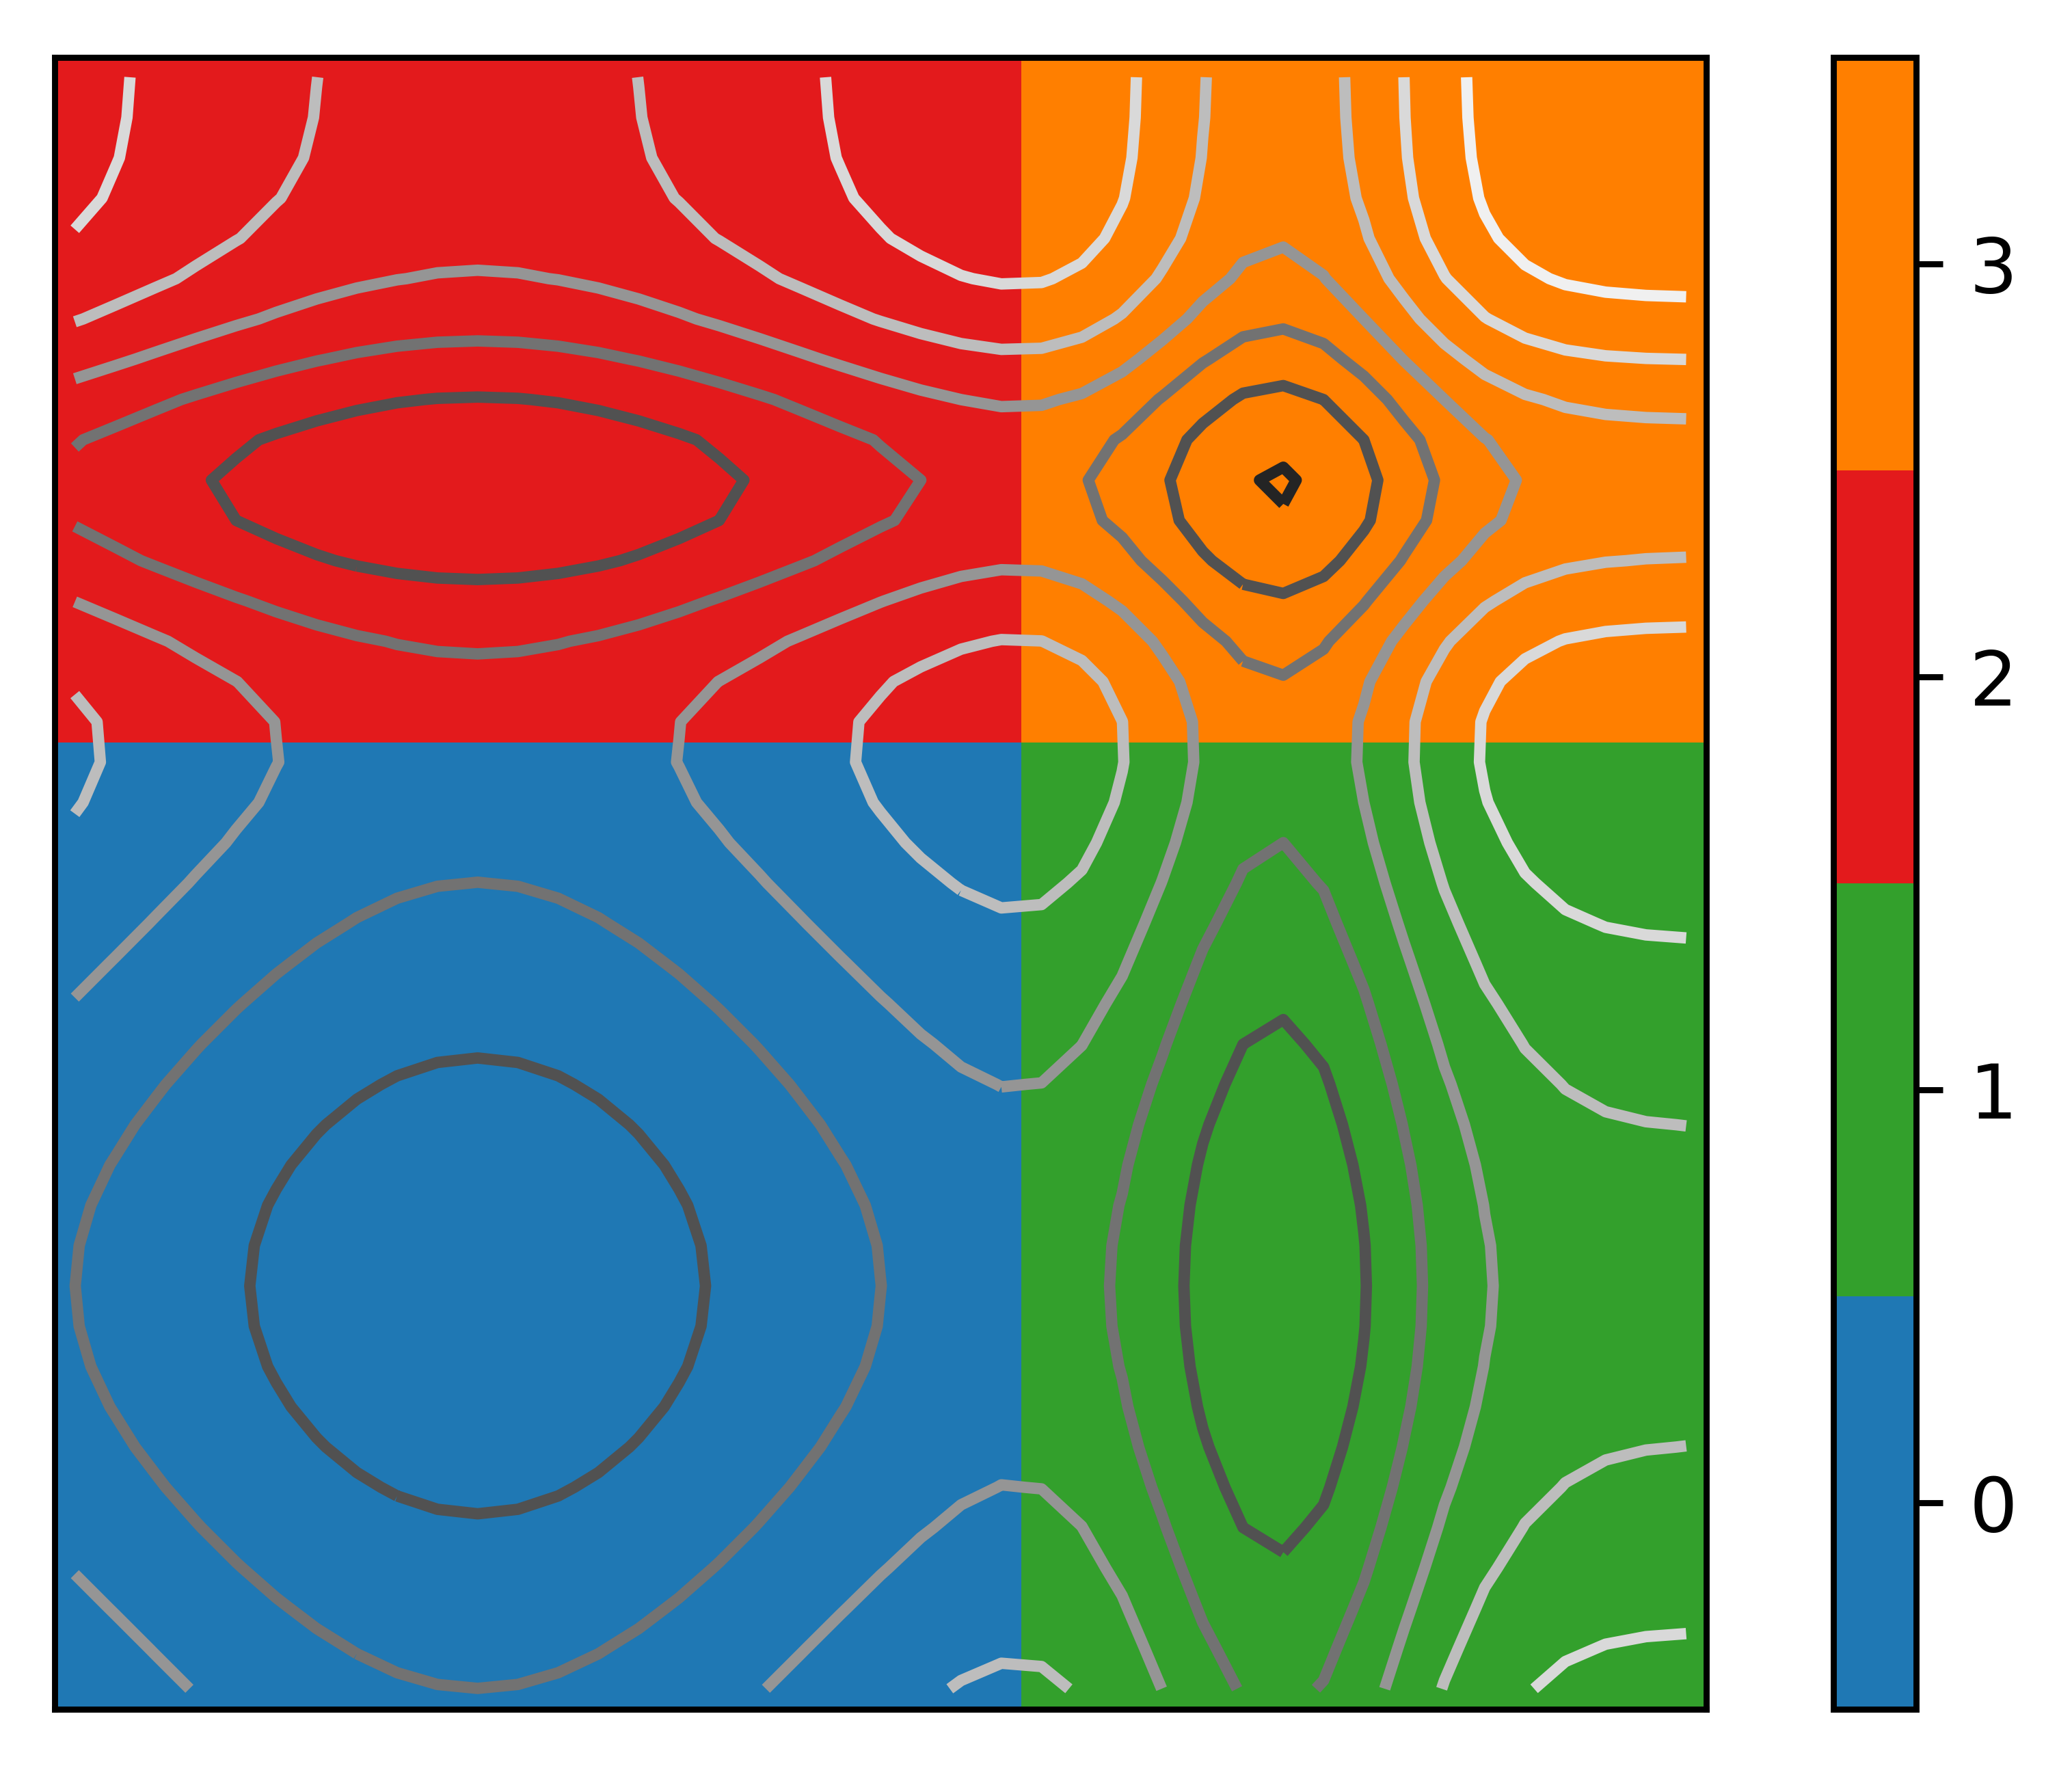

In [10]:
plot_realization(ground_truth)
plt.savefig("{}/gt.png".format(my_dir), bbox_inches='tight')

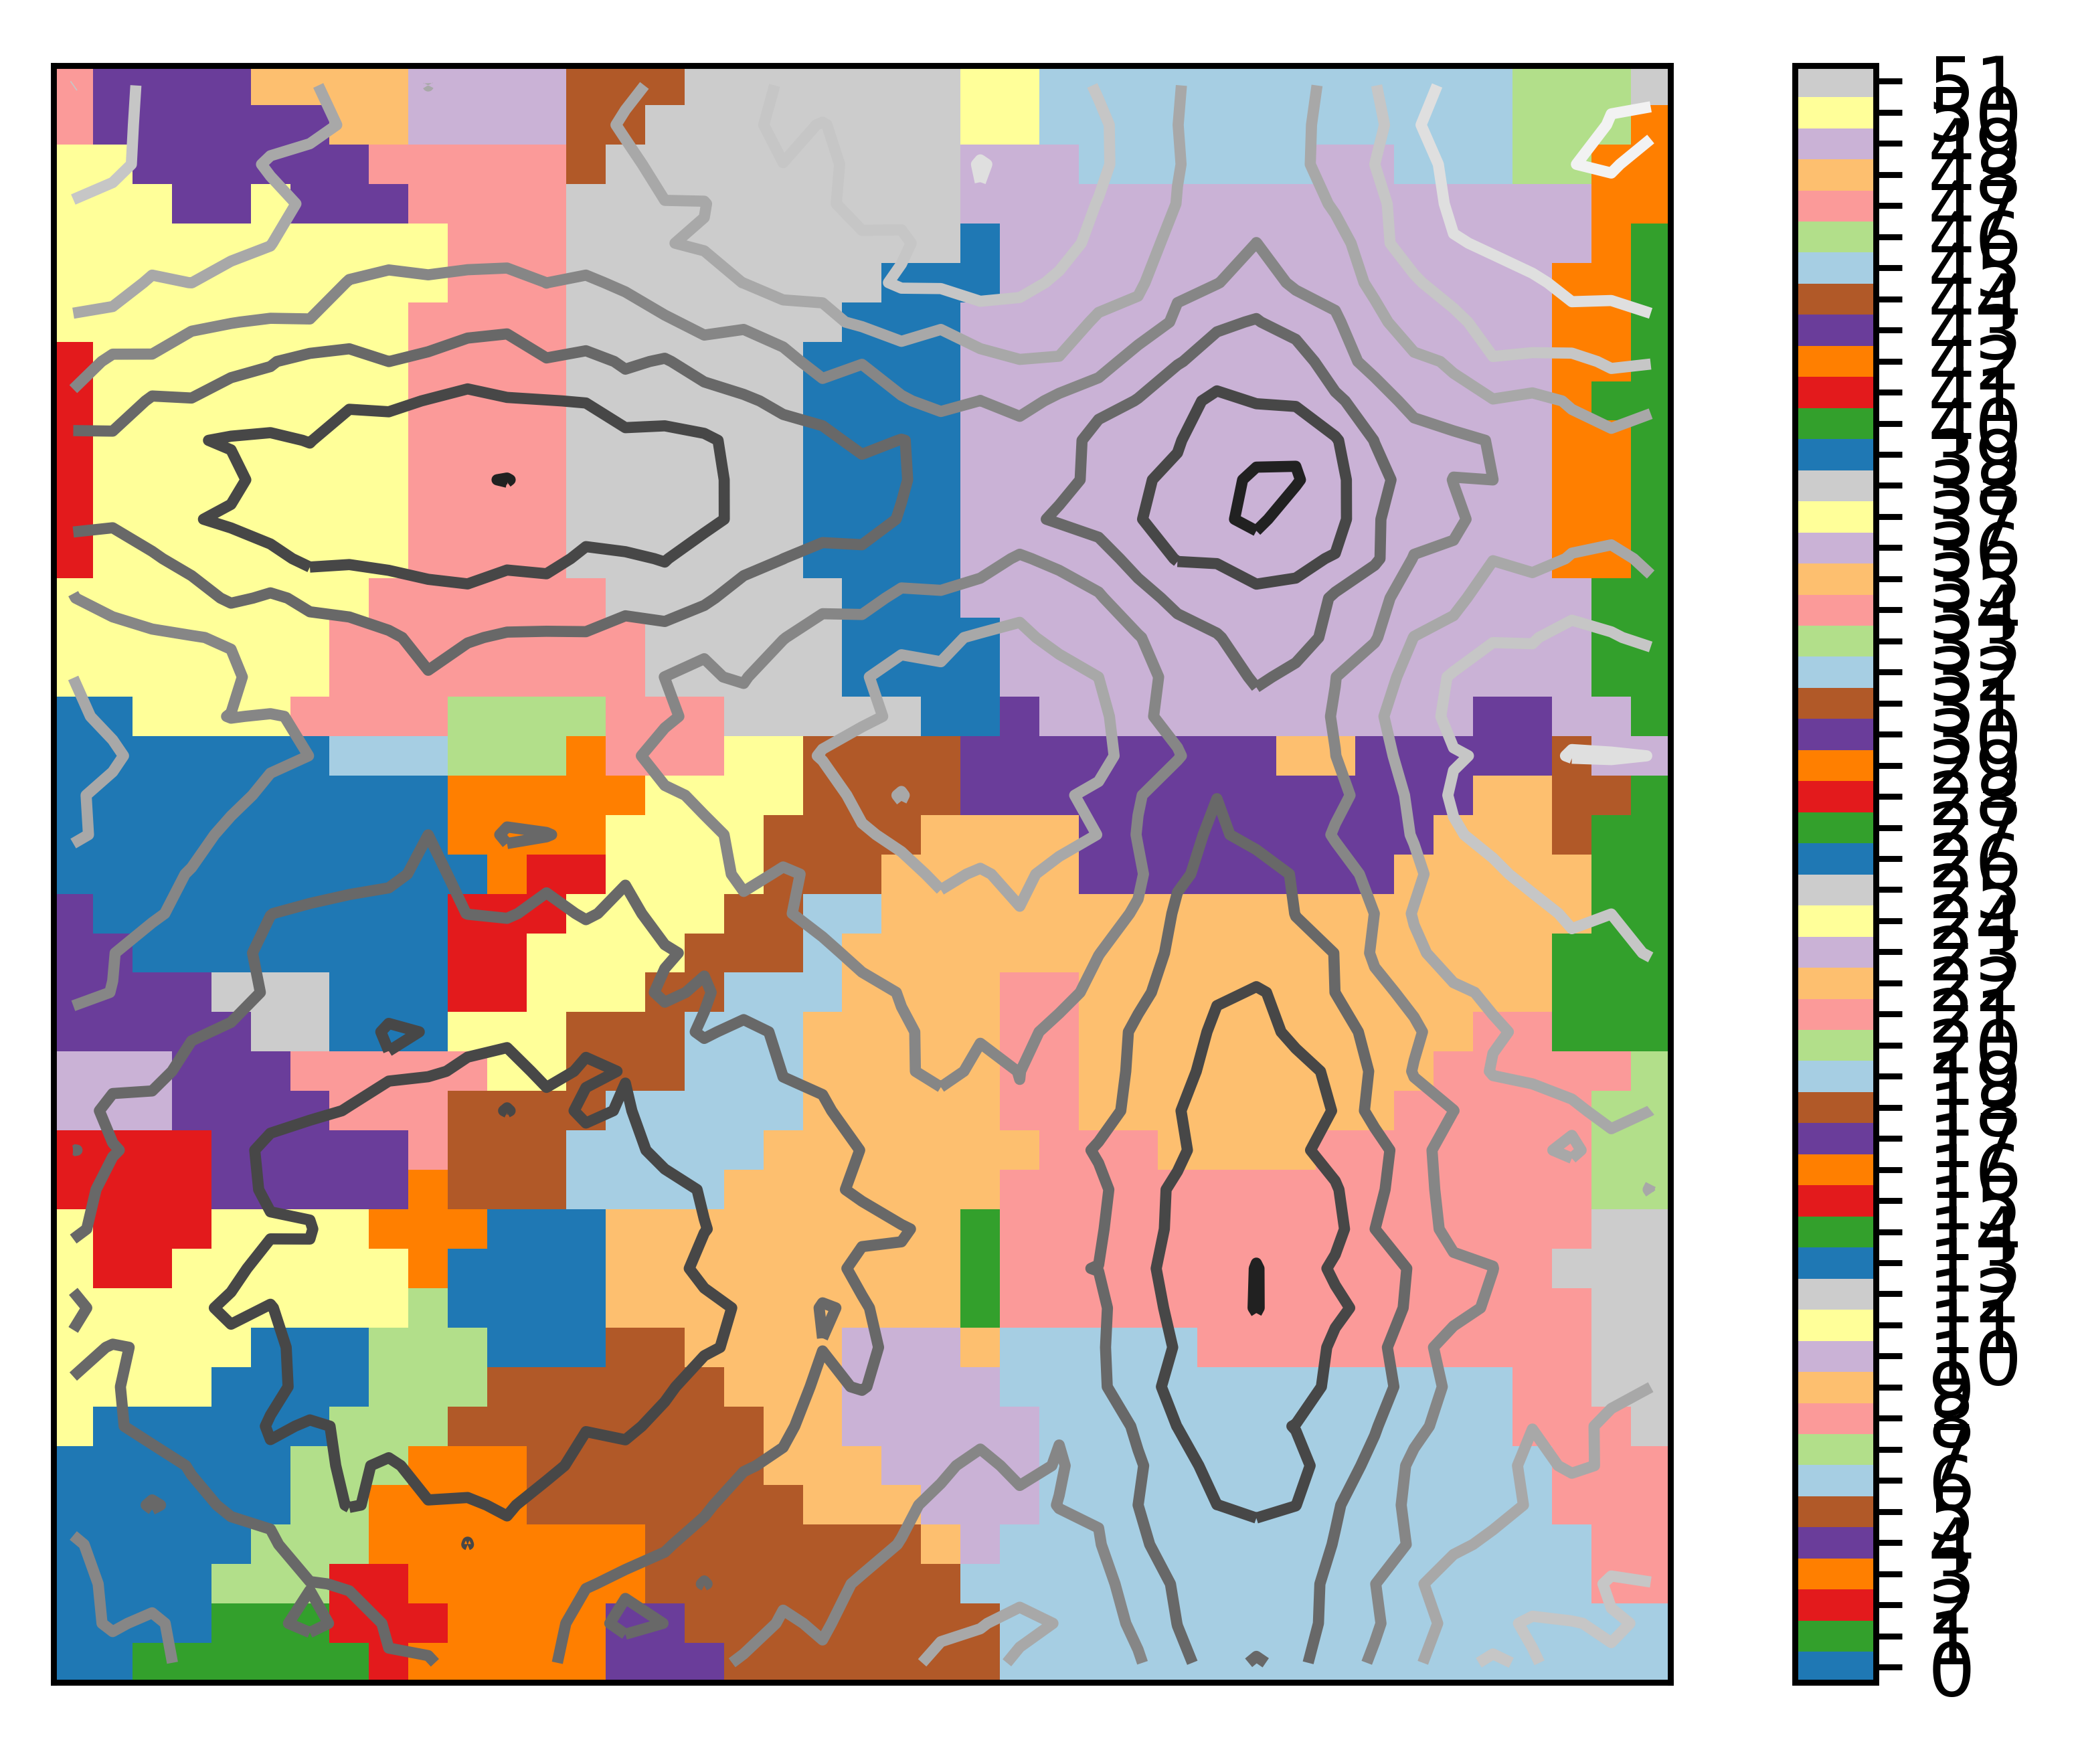

In [11]:
plot_realization(uncertain_realizations[:,:,2])
plt.savefig("{}/realization_0.png".format(my_dir), bbox_inches='tight')

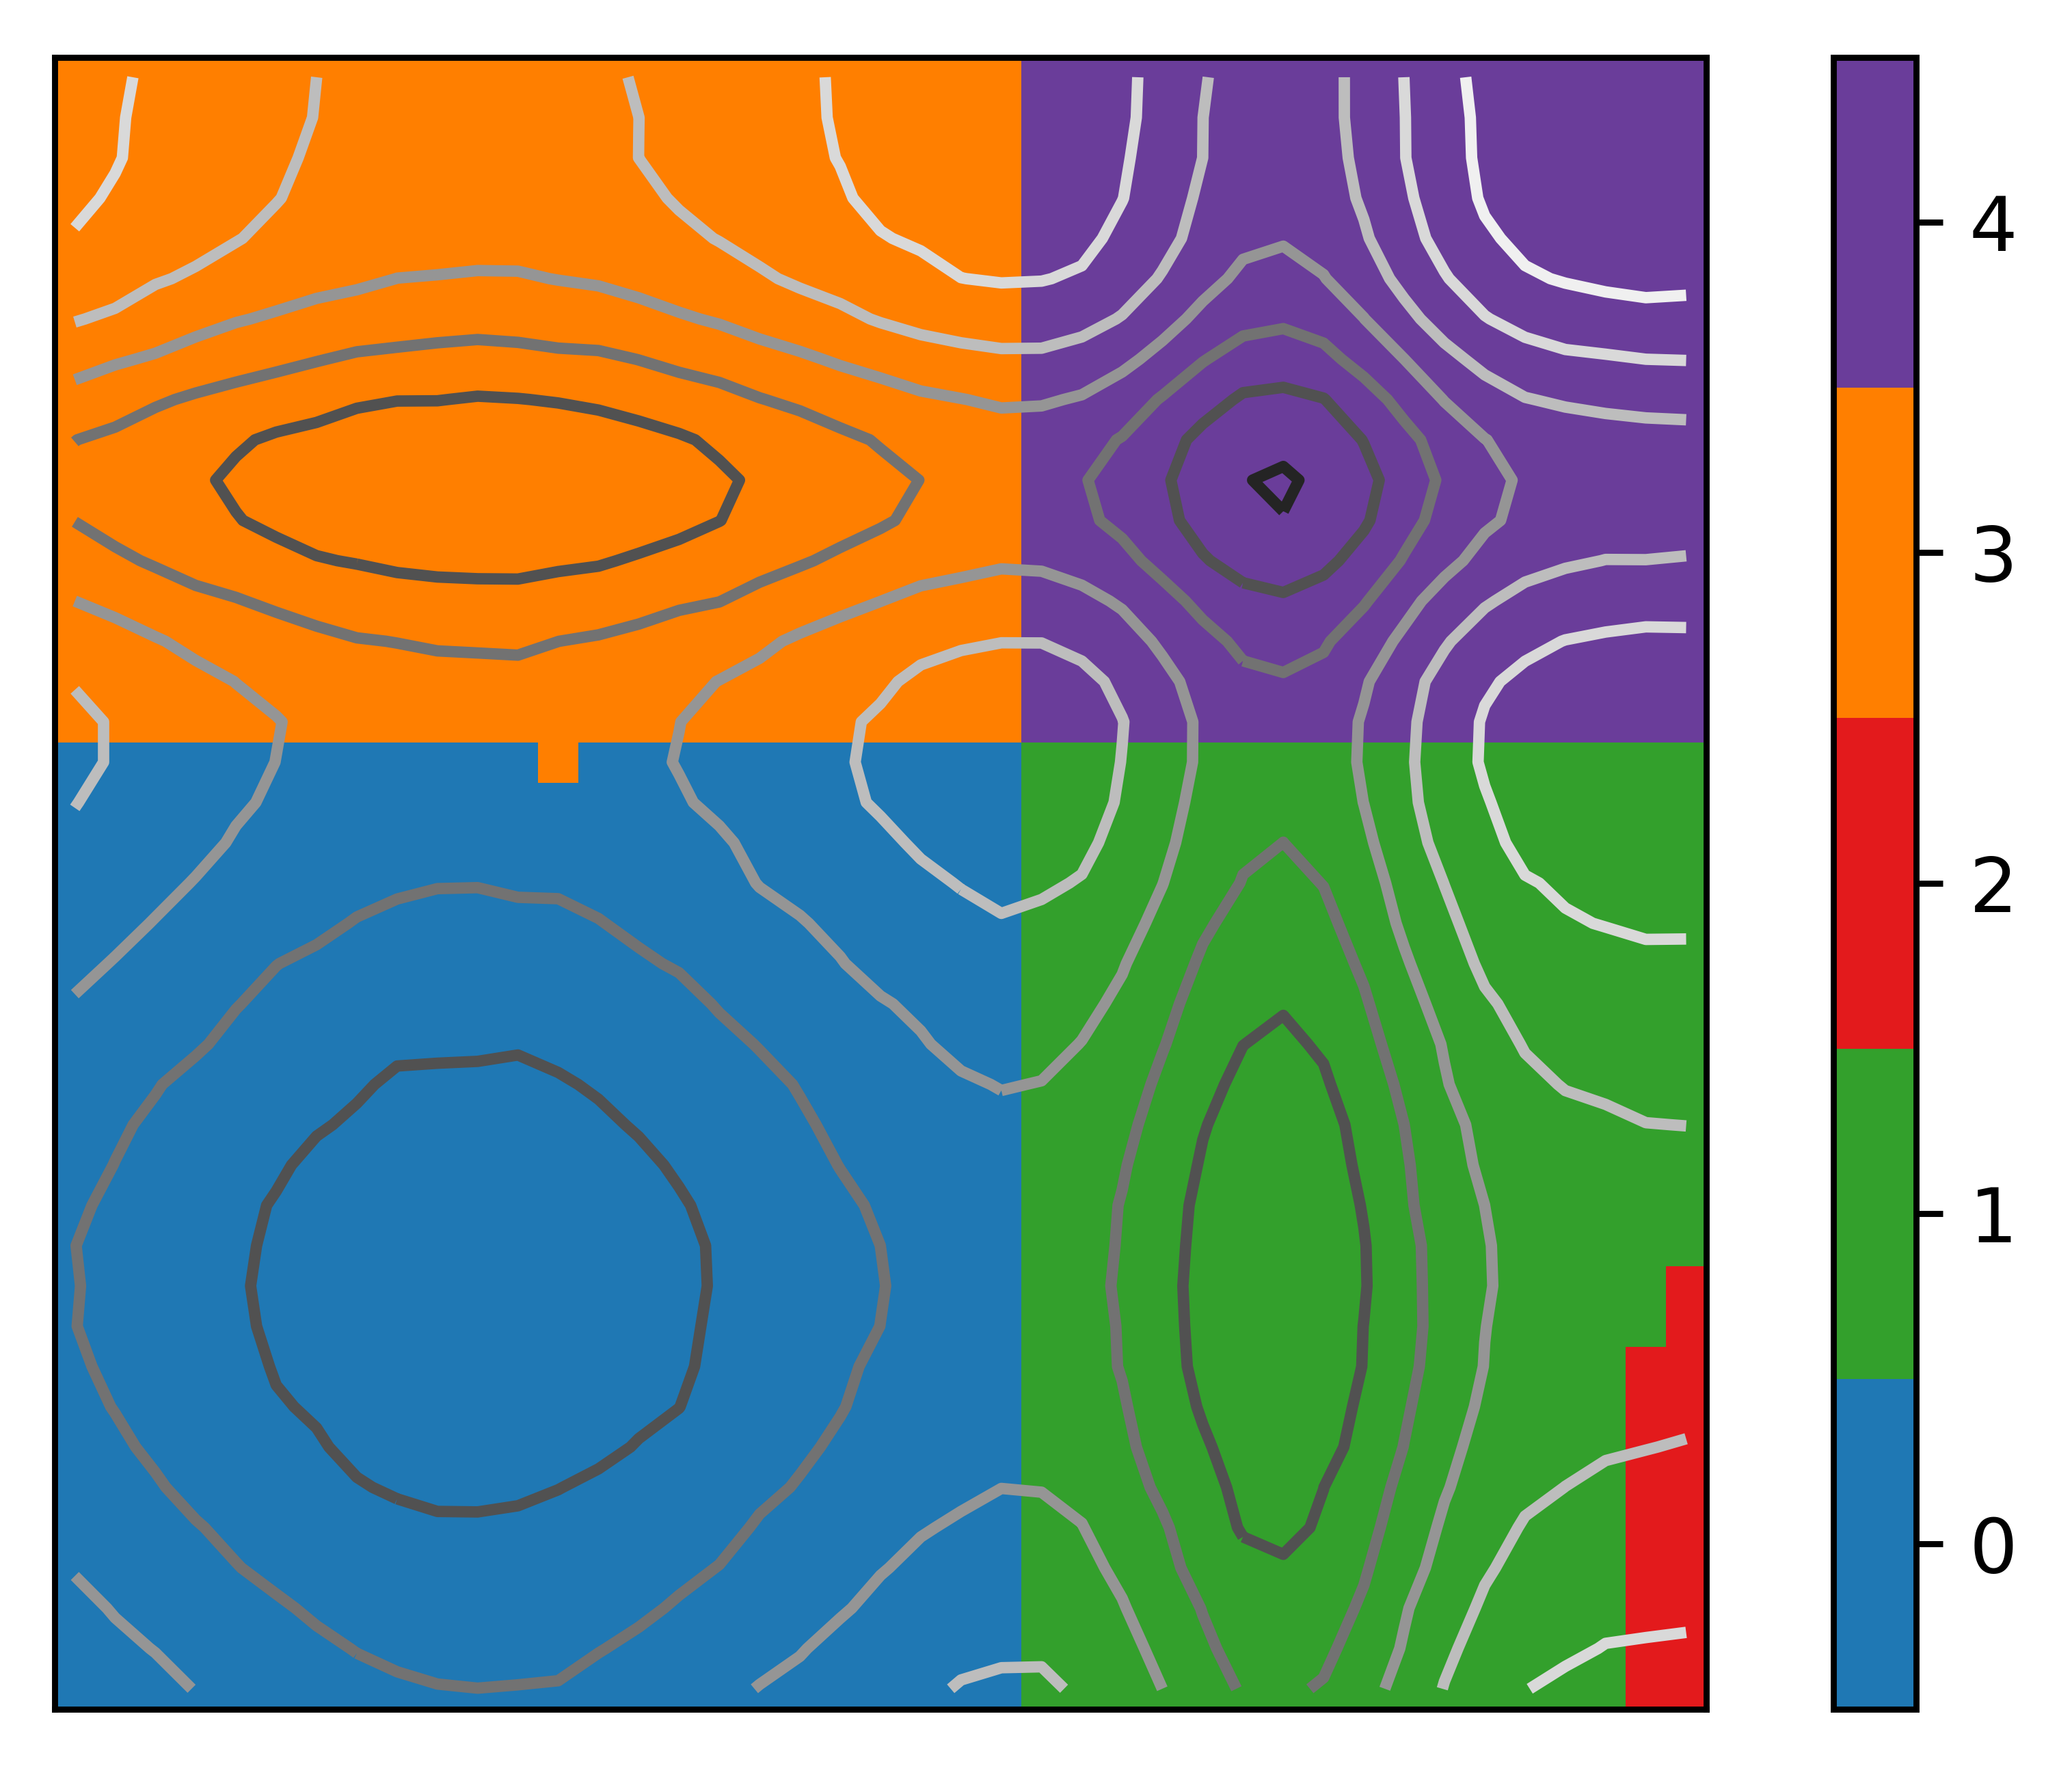

In [12]:
plot_realization(mean_realization)
plt.savefig("{}/realization_mean.png".format(my_dir), bbox_inches='tight')

In [13]:
# %matplotlib inline

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# xi = np.linspace(0, 1, 41)
# X, Y = np.meshgrid(xi, xi)
# img = ax.plot_surface(X=X, Y=Y, Z=ground_truth)

In [14]:
all_counts = np.zeros(uncertain_realizations[:,:,0].shape)
all_weighted_counts = np.zeros(uncertain_realizations[:,:,0].shape)
for i in range(uncertain_realizations.shape[2]):
# for i in range(1):
    counts, weighted_counts = count_persistence(uncertain_realizations[:,:,i])
    all_counts += counts
    all_weighted_counts += weighted_counts

2535.0


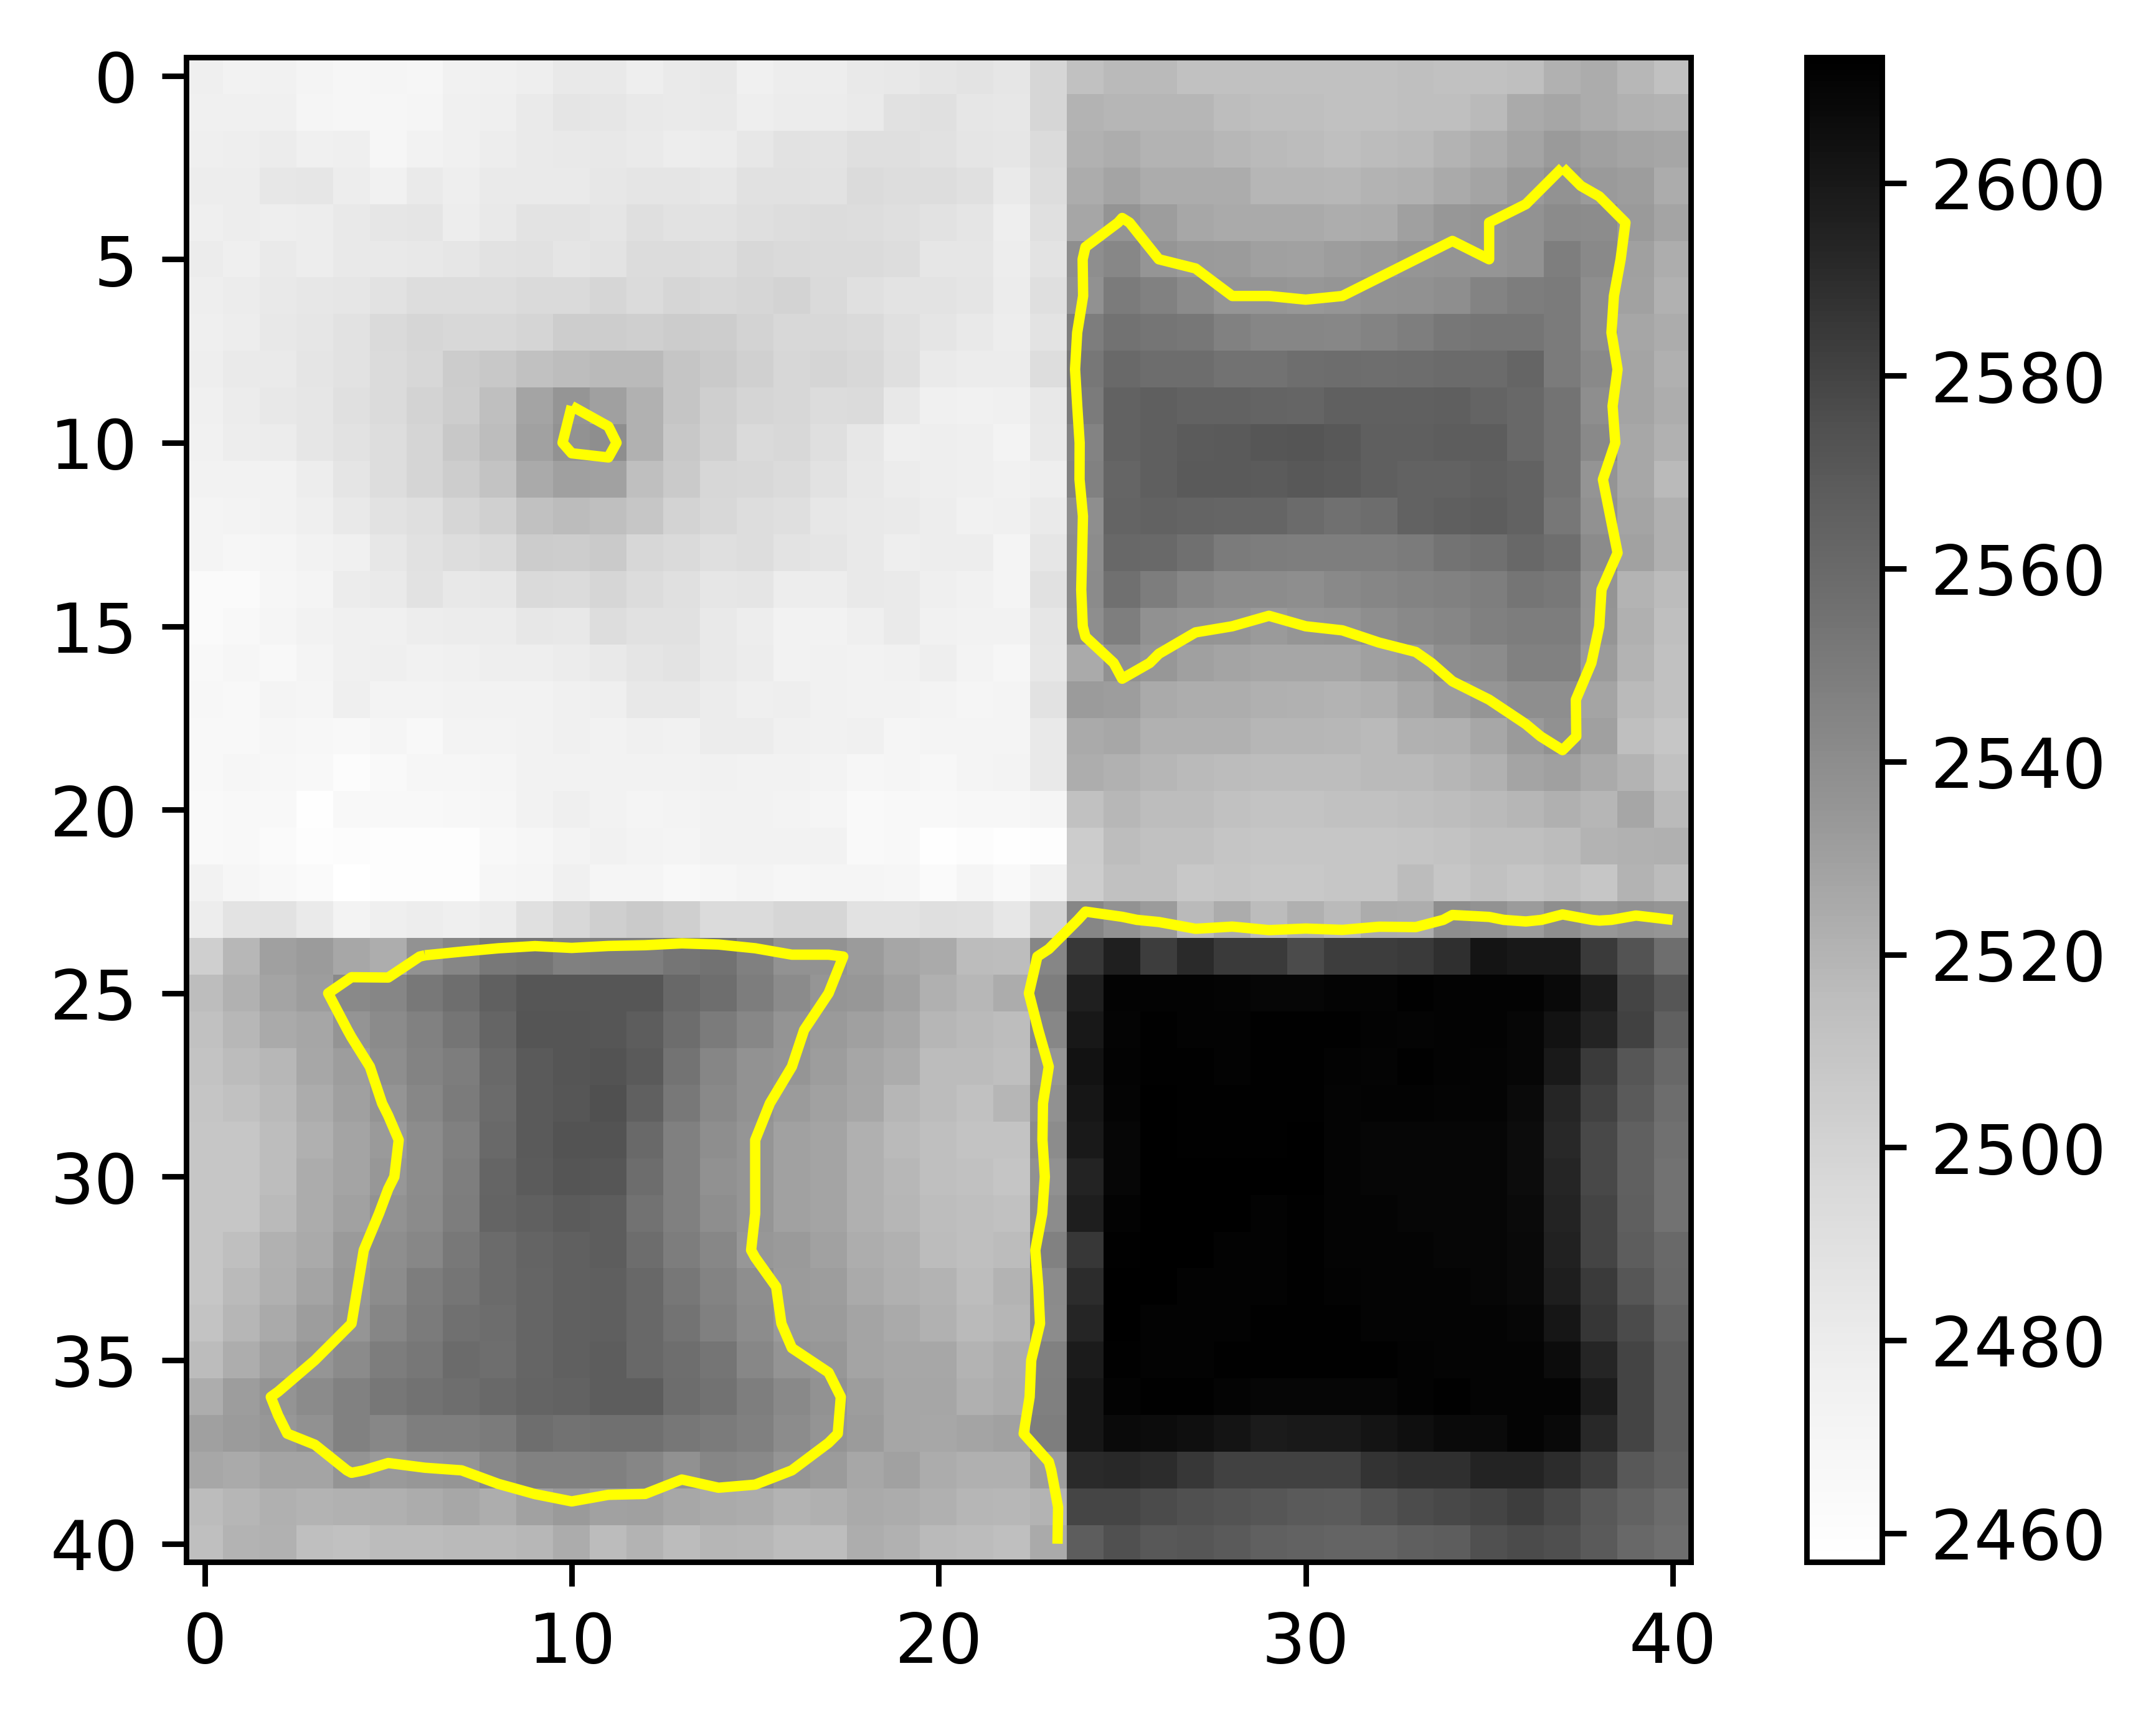

In [15]:
plt.figure(dpi=800)
img = plt.imshow(all_counts, cmap=cm.Greys)
plt.colorbar(img)
k = (np.max(all_counts) + np.min(all_counts)) / 2.
print(k)
plt.contour(all_counts, levels=[k], colors='#FFFF00')
plt.savefig("{}/survival_count.png".format(my_dir), bbox_inches='tight')

5081.712848999999


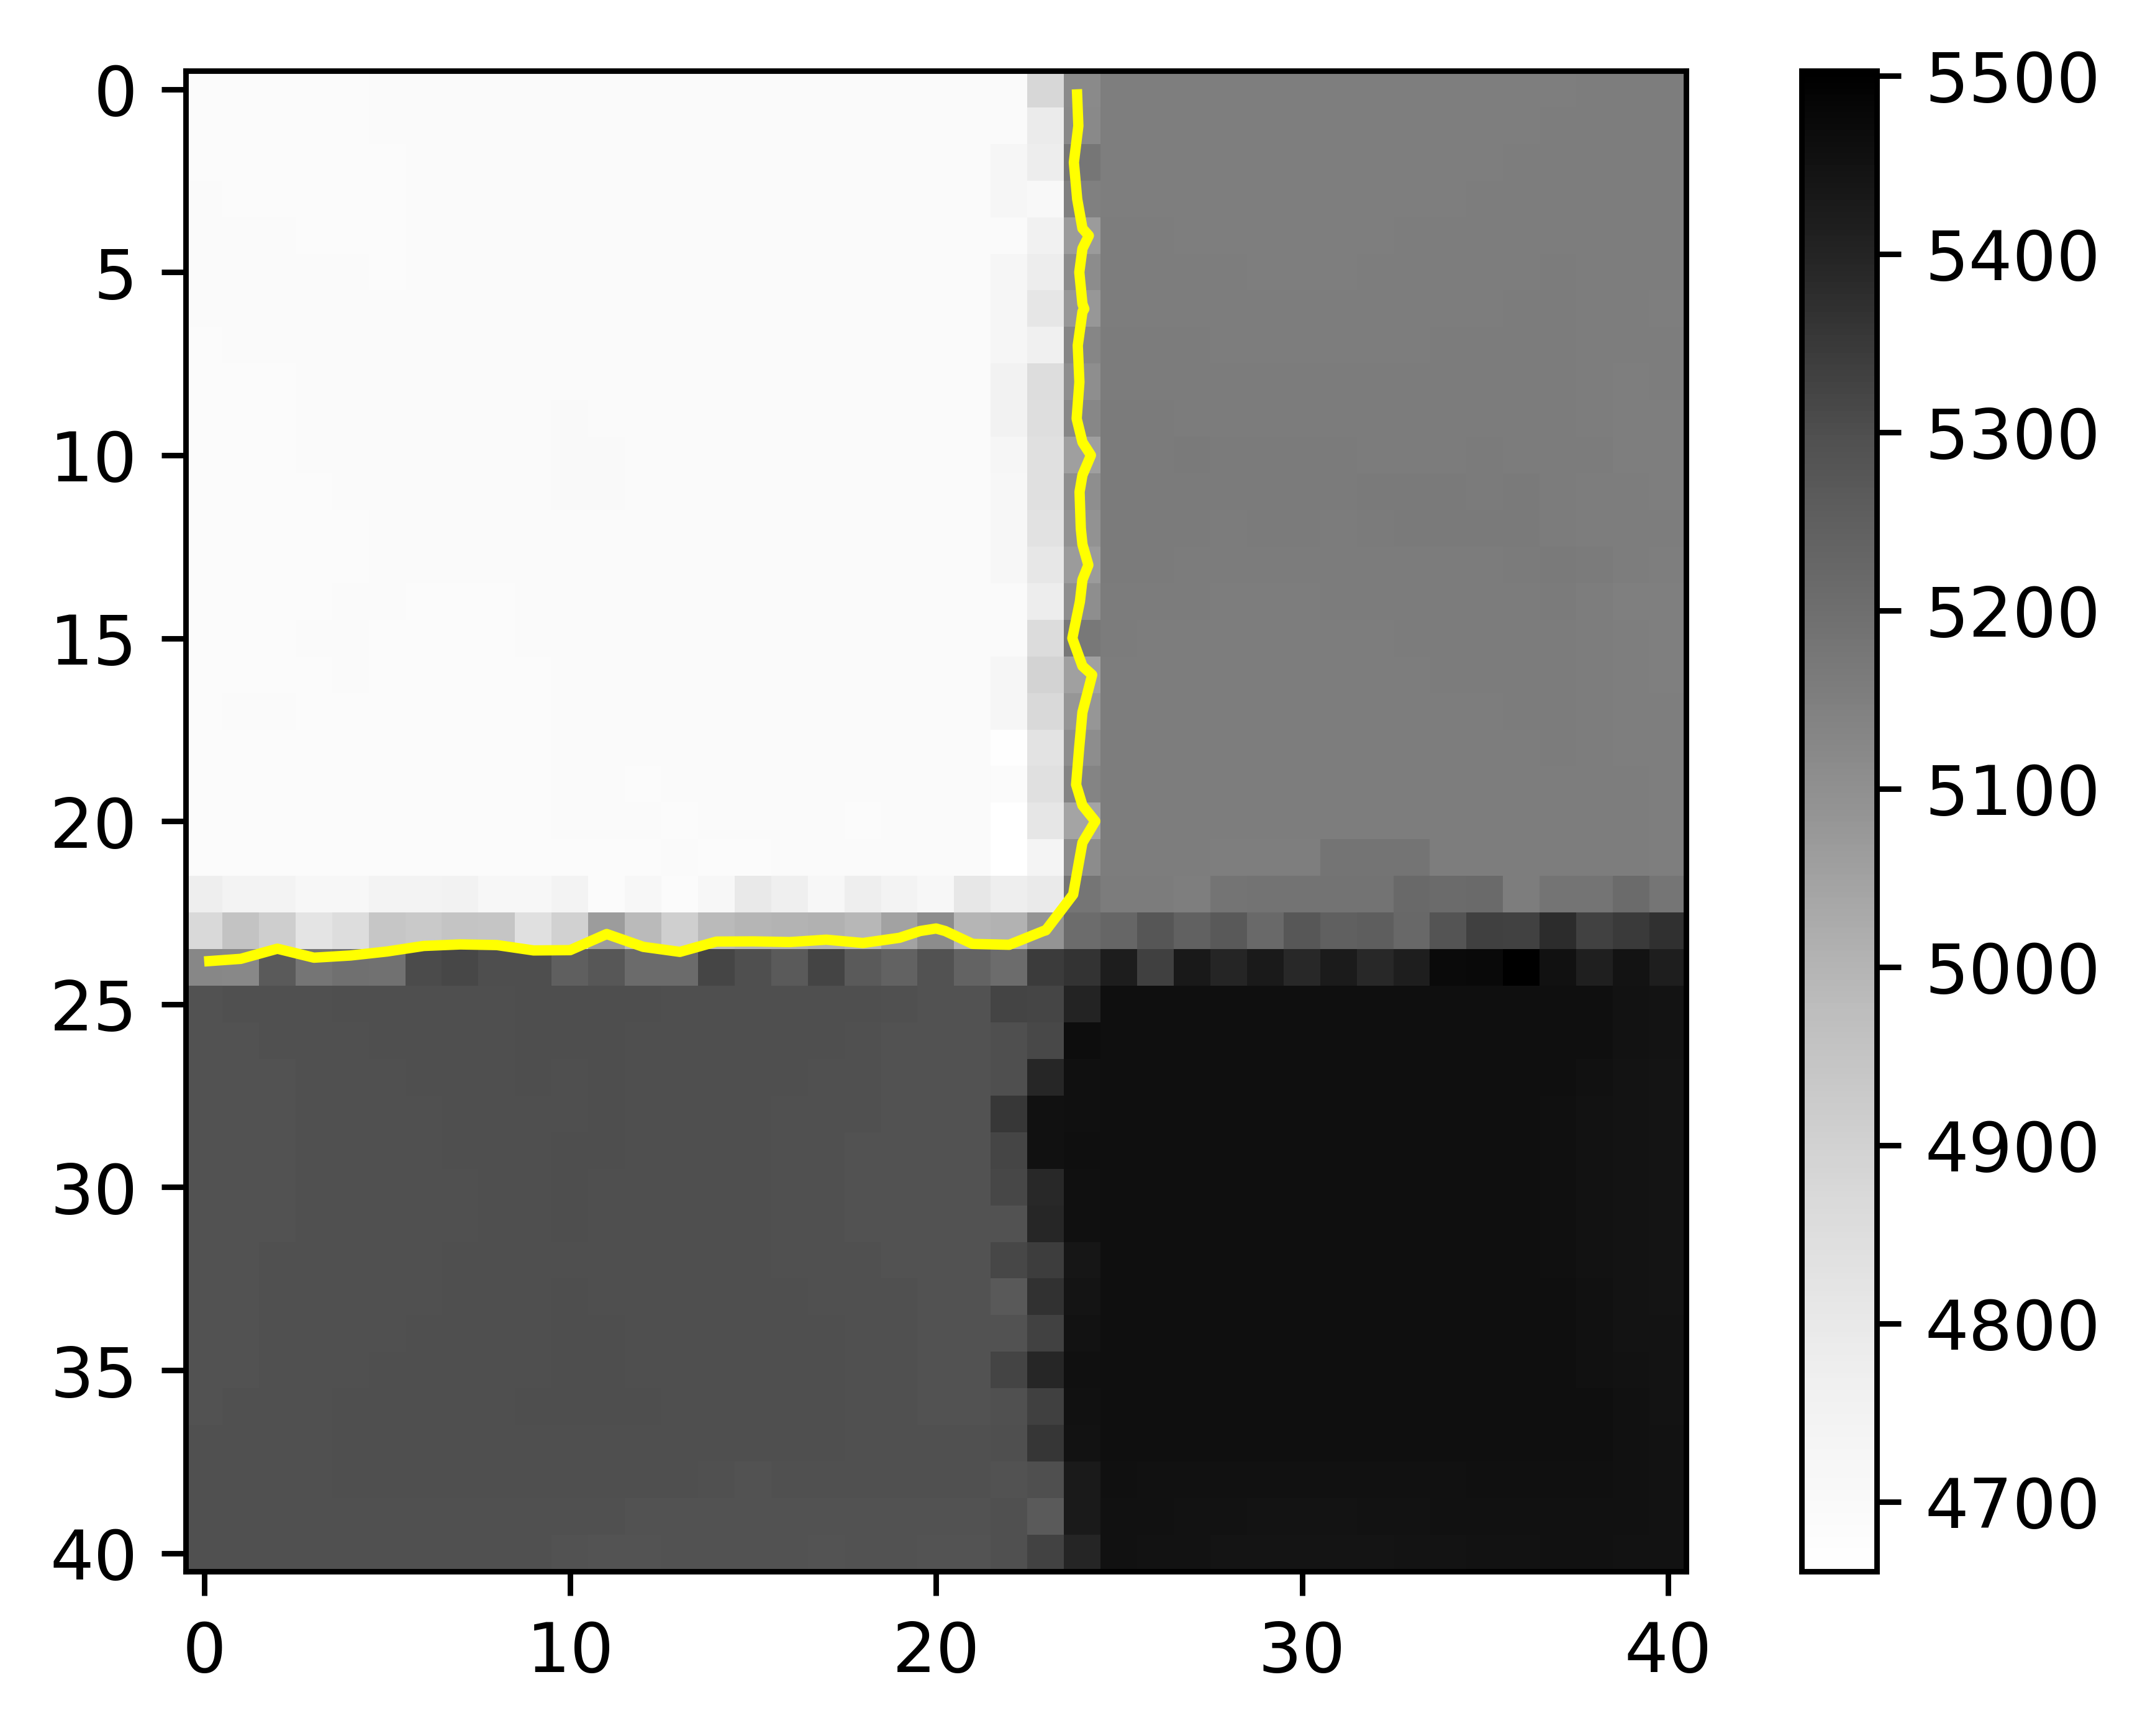

In [16]:
plt.figure(dpi=800)
img2 = plt.imshow(all_weighted_counts, cmap=cm.Greys)
plt.colorbar(img2)
k = (np.max(all_weighted_counts) + np.min(all_weighted_counts)) / 2.
print(k)
plt.contour(all_weighted_counts, levels=[k], colors='#FFFF00')
plt.savefig("{}/weighted_survival_count.png".format(my_dir), bbox_inches='tight')

/home/maljovec/miniconda3/envs/gpu/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


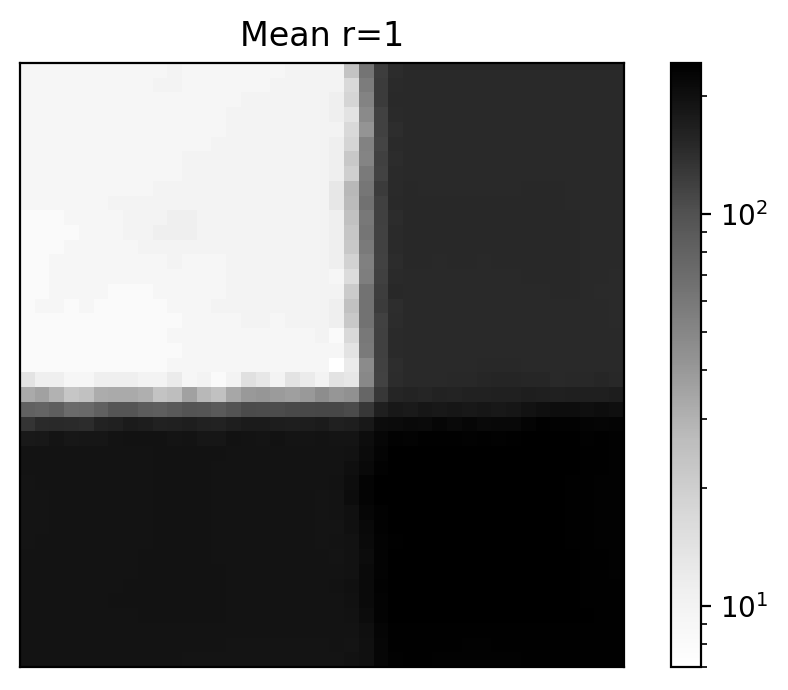

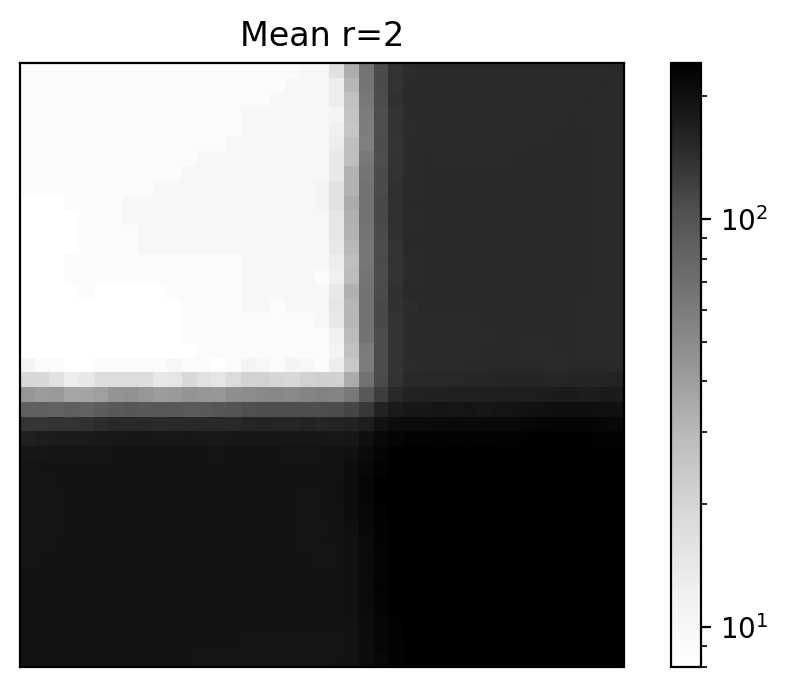

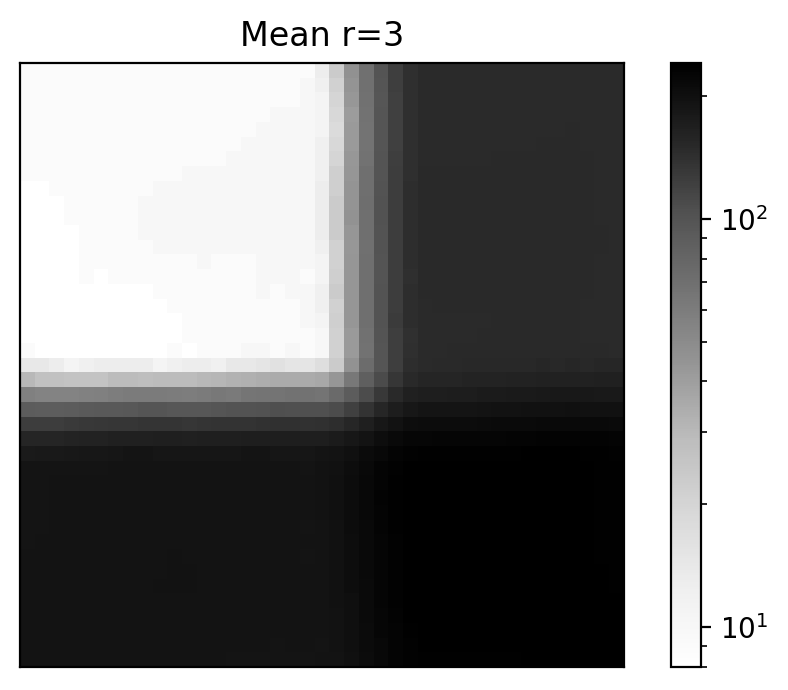

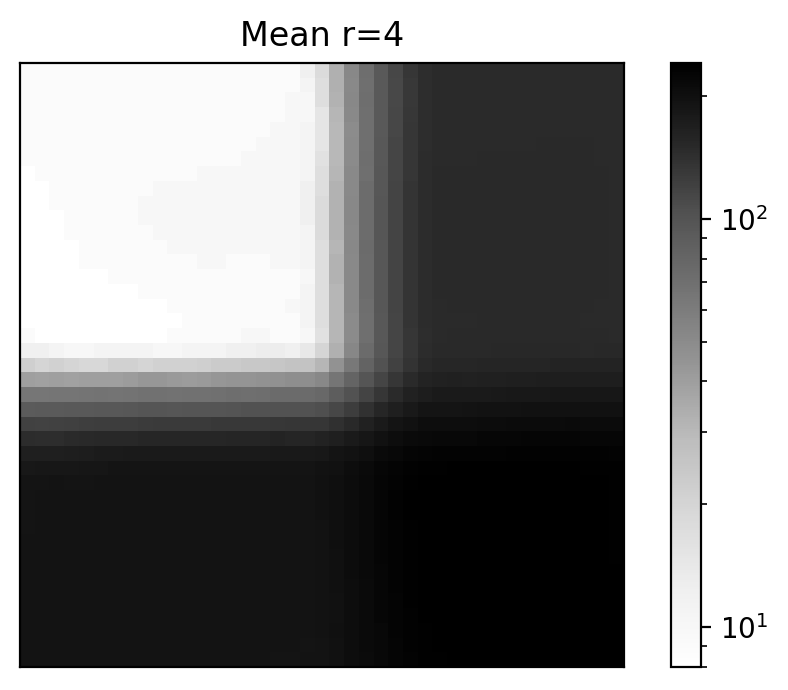

In [17]:
mean_images = []
max_radius = 5

image = (all_weighted_counts - np.min(all_weighted_counts)) / (np.max(all_weighted_counts) - np.min(all_weighted_counts))
eps=1e-16
for i in range(1, max_radius):
    mean_images.append(filters.rank.mean(image, selem=morphology.disk(i)))
    show_image(mean_images[-1]+eps)
    plt.gca().set_title("Mean r={}".format(i))

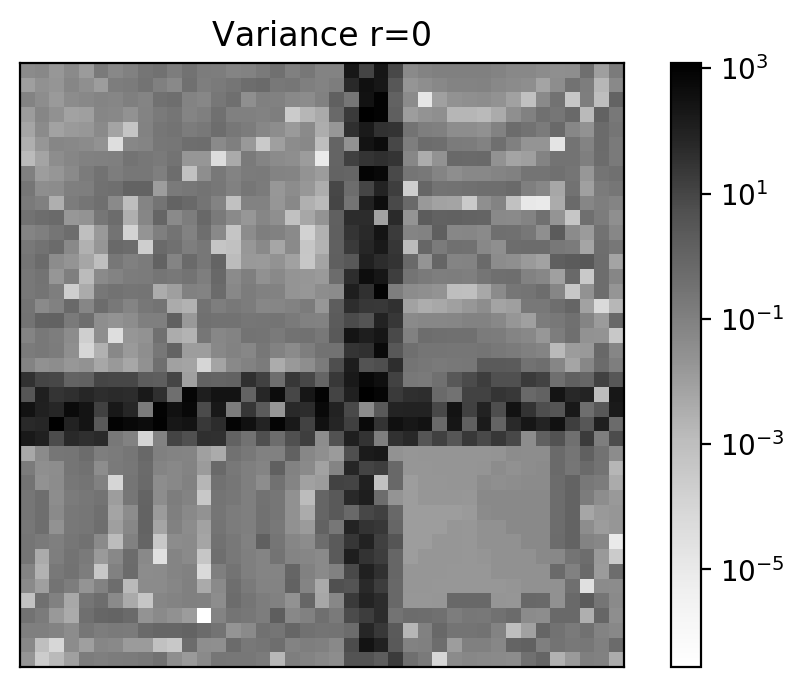

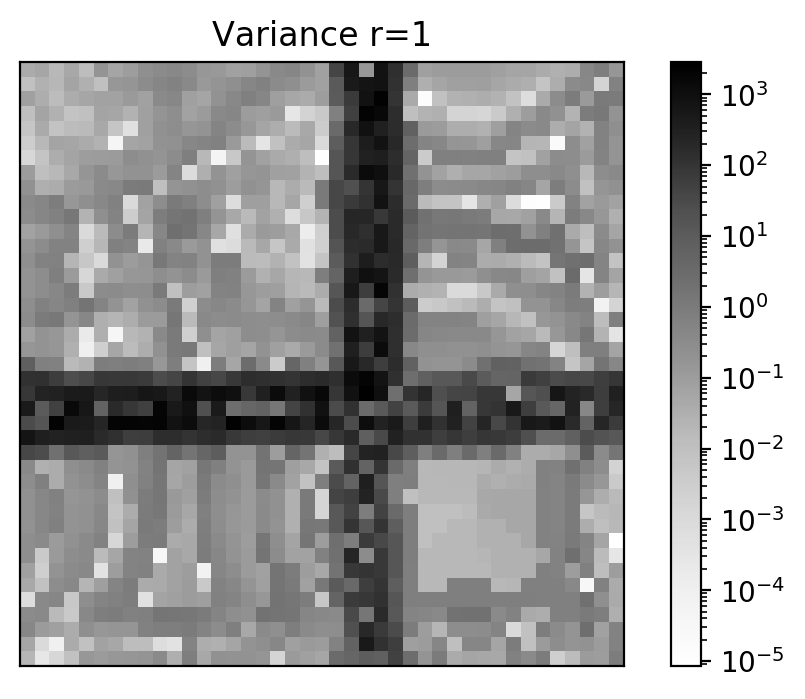

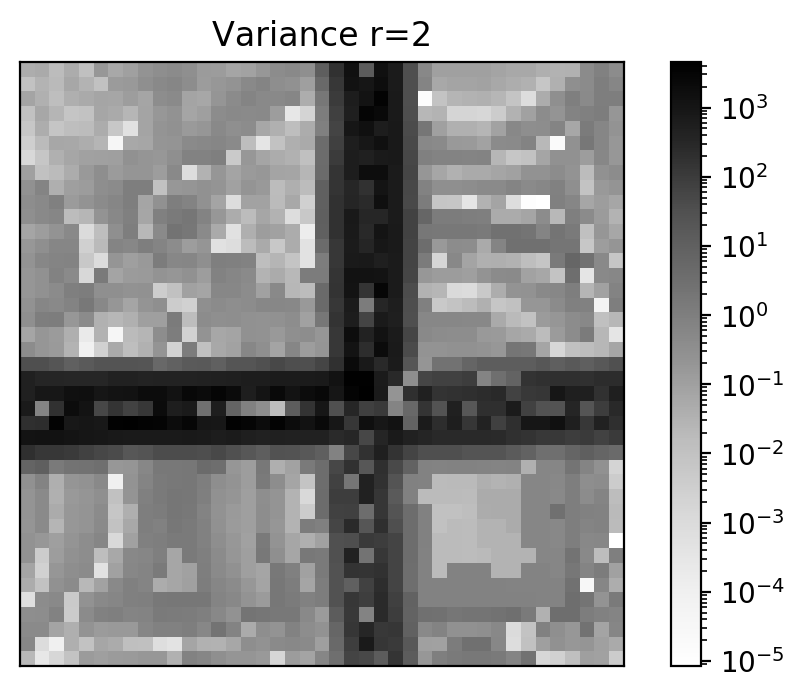

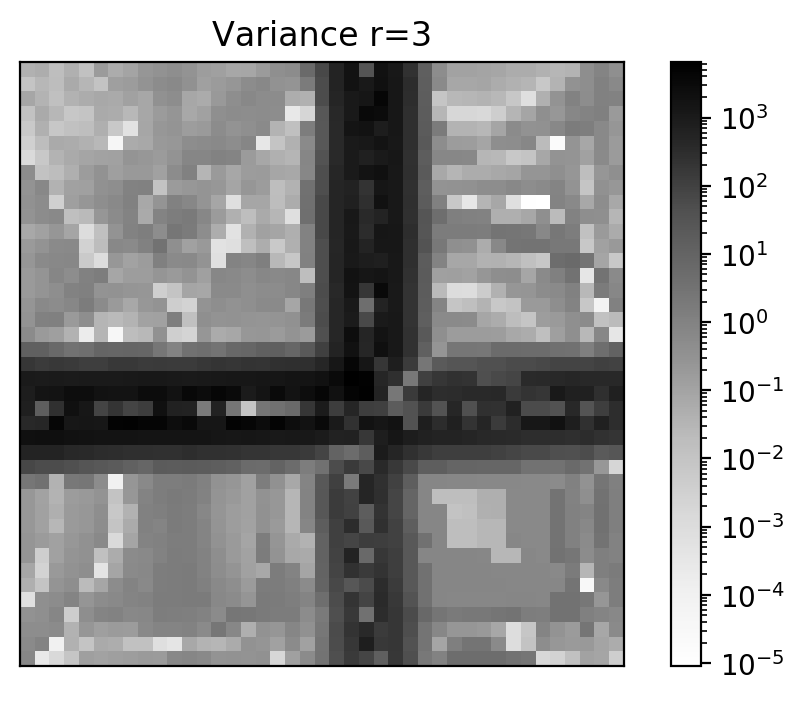

In [18]:
image = 255*image
variance_images = []
eps=1e-16
for i, mean_image in enumerate(mean_images):
    variance_images.append(np.power(image-mean_image,2)+eps)
    show_image(variance_images[-1])
    plt.gca().set_title("Variance r={}".format(i))

plt.savefig("{}/weighted_surival_count_variance.png".format(my_dir), bbox_inches='tight')

In [19]:
ps = []
fields = []
for i in range(uncertain_realizations.shape[2]):
    field, p = assignments(uncertain_realizations[:,:,i])
    ps.append(p)
    fields.append(field)
    
ps = np.array(ps)
fields = np.array(fields)
print(np.min(ps), np.max(ps), np.mean(ps), np.std(ps))

30.8503 35.7714 33.156064 1.132648270516492


/home/maljovec/miniconda3/envs/gpu/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


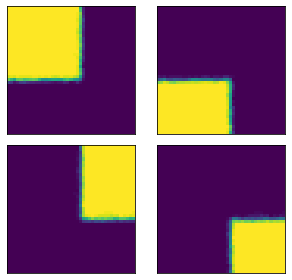

In [20]:
num_partitions = len(np.unique(fields[0]))
shape = (num_partitions,) + fields[0].shape
label_images = np.zeros(shape)

dim1 = int(np.ceil(np.sqrt(num_partitions)))
dim2 = int(np.floor(num_partitions/dim1+0.5))
fig, axes = plt.subplots(dim1, dim2, tight_layout=True)

axes = axes.flatten()

for i in range(num_partitions):
    test_image = (fields == i)
    label_images[i] = np.sum(test_image, axis=0)
    img = axes[i].imshow(label_images[i])
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
for i in range(num_partitions, dim1*dim2):
    axes[i].set_visible(False)

plt.savefig("{}/partition_probabilities.png".format(my_dir), bbox_inches='tight')

# fig.colorbar(img, ax=axes.ravel().tolist())

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(img, cax=cbar_ax)

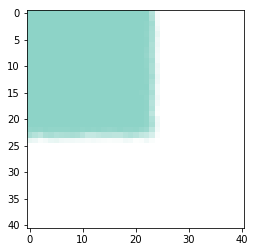

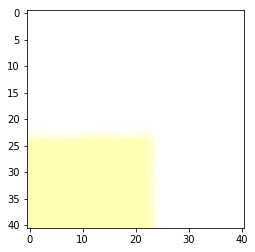

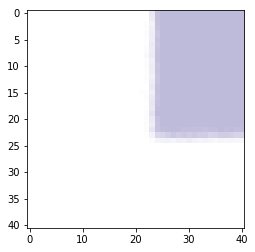

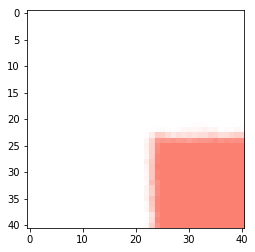

In [21]:
color_list = [[141,211,199], [255,255,179], [190,186,218],
              [251,128,114], [128,177,211], [253,180,98],
              [179,222,105], [252,205,229], [217,217,217]]
# color_list = [[105,239,123], [149,56,144], [192,222,164],
#                 [14,80,62], [153,222,249], [24,81,155],
#                 [218,185,255], [66,30,200], [183,211,33]]
# color_list = [[251,180,174],[179,205,227],[204,235,197],
#               [222,203,228],[254,217,166],[255,255,204],
#               [229,216,189],[253,218,236],[242,242,242]]

ccycle = cycle(color_list)

colored_images = []
for i, c in zip(range(num_partitions), ccycle):
    colored_image = np.zeros(label_images[0].shape + (4,))
    colored_image[:,:,0] = c[0]/255.
    colored_image[:,:,1] = c[1]/255.
    colored_image[:,:,2] = c[2]/255.
    colored_images.append(colored_image)

for i, label_image in enumerate(label_images):
    colored_images[i][:,:, 3] = label_image / 50.

for i in range(num_partitions):
    plt.figure()
    plt.imshow(colored_images[i])

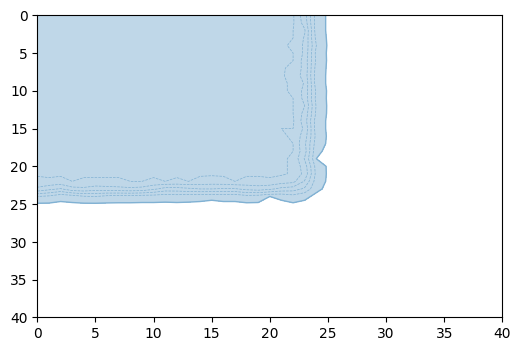

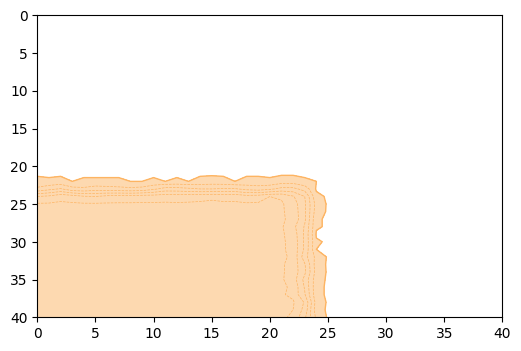

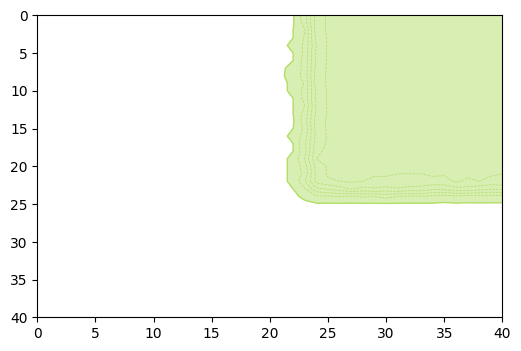

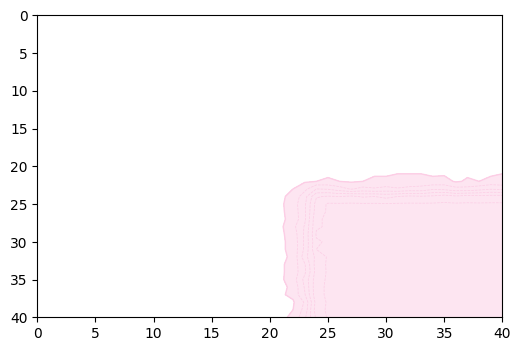

In [22]:
for i, color in zip(range(num_partitions), ccycle):
    my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
    plt.figure(dpi=100)
    plt.contourf(colored_images[i][:,:, 3], levels=[0.02, 1.0], colors=my_color, alpha=0.5)
    plt.contour(colored_images[i][:,:, 3], levels=[0.02, 0.2, 0.4, 0.6, 0.8, 0.98], colors=my_color, linewidths=[1, 0.5, 0.5, 0.5, 0.5, 0.5], linestyles=['solid','dashed','dashed','dashed','dashed','dashed'])
    plt.gca().set_ylim(40, 0)

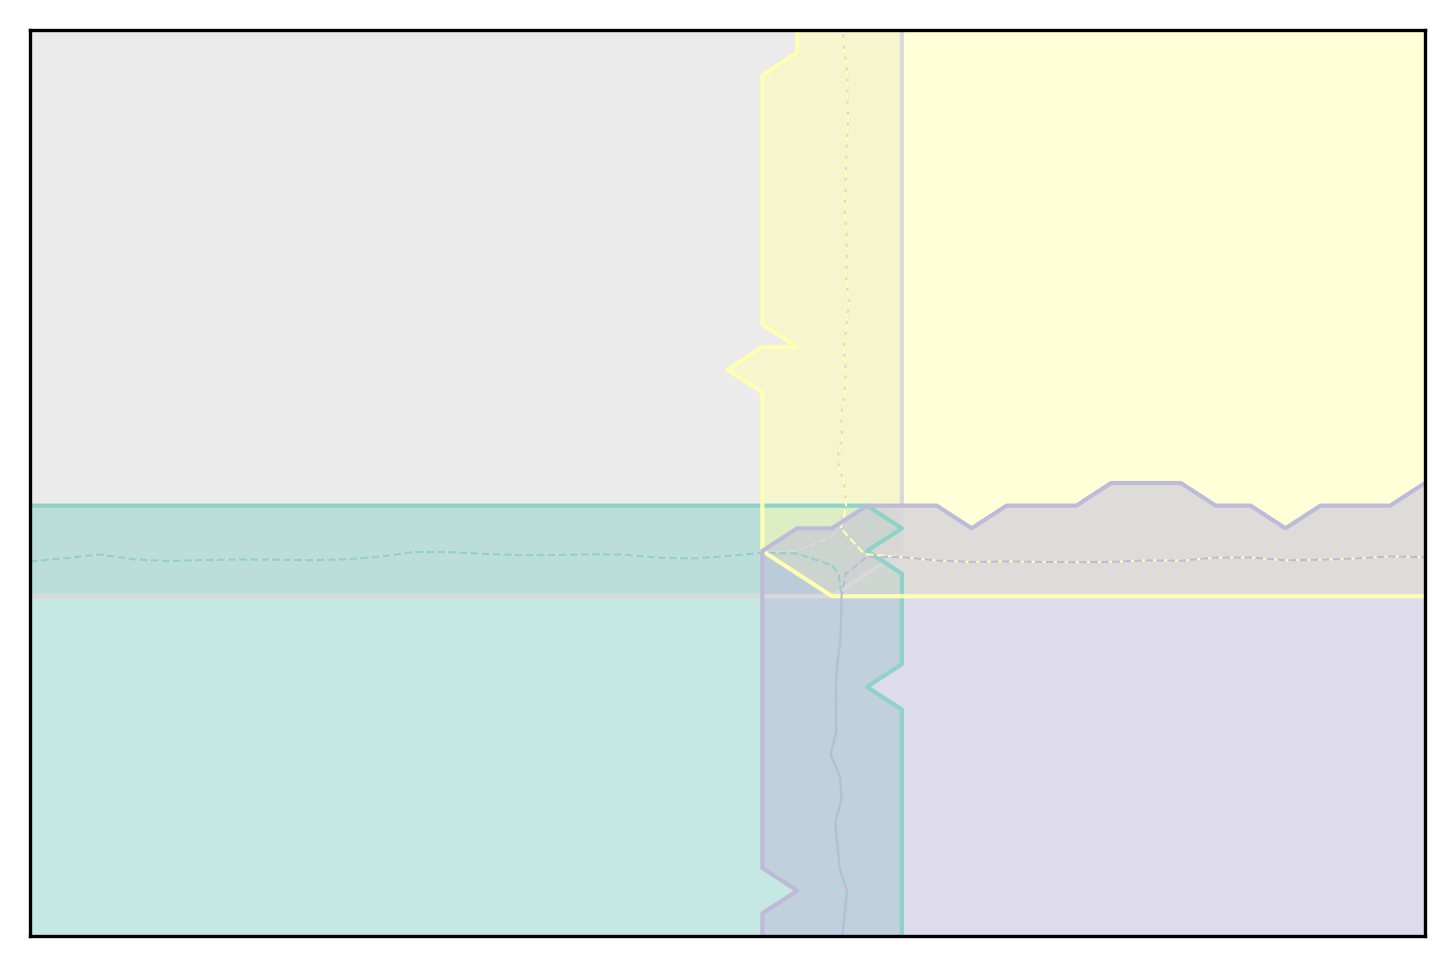

In [23]:
plt.figure(dpi=300)
for i, color in zip(range(num_partitions), ccycle):
    my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
    plt.contourf(colored_images[i][:,:, 3], levels=[1e-6, 1], colors=my_color, alpha=0.5)
    plt.contour(colored_images[i][:,:, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[1, 0.5, 1.0], linestyles=['solid','dashed','solid'])

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
_ = ax.set_ylim(40, 0)

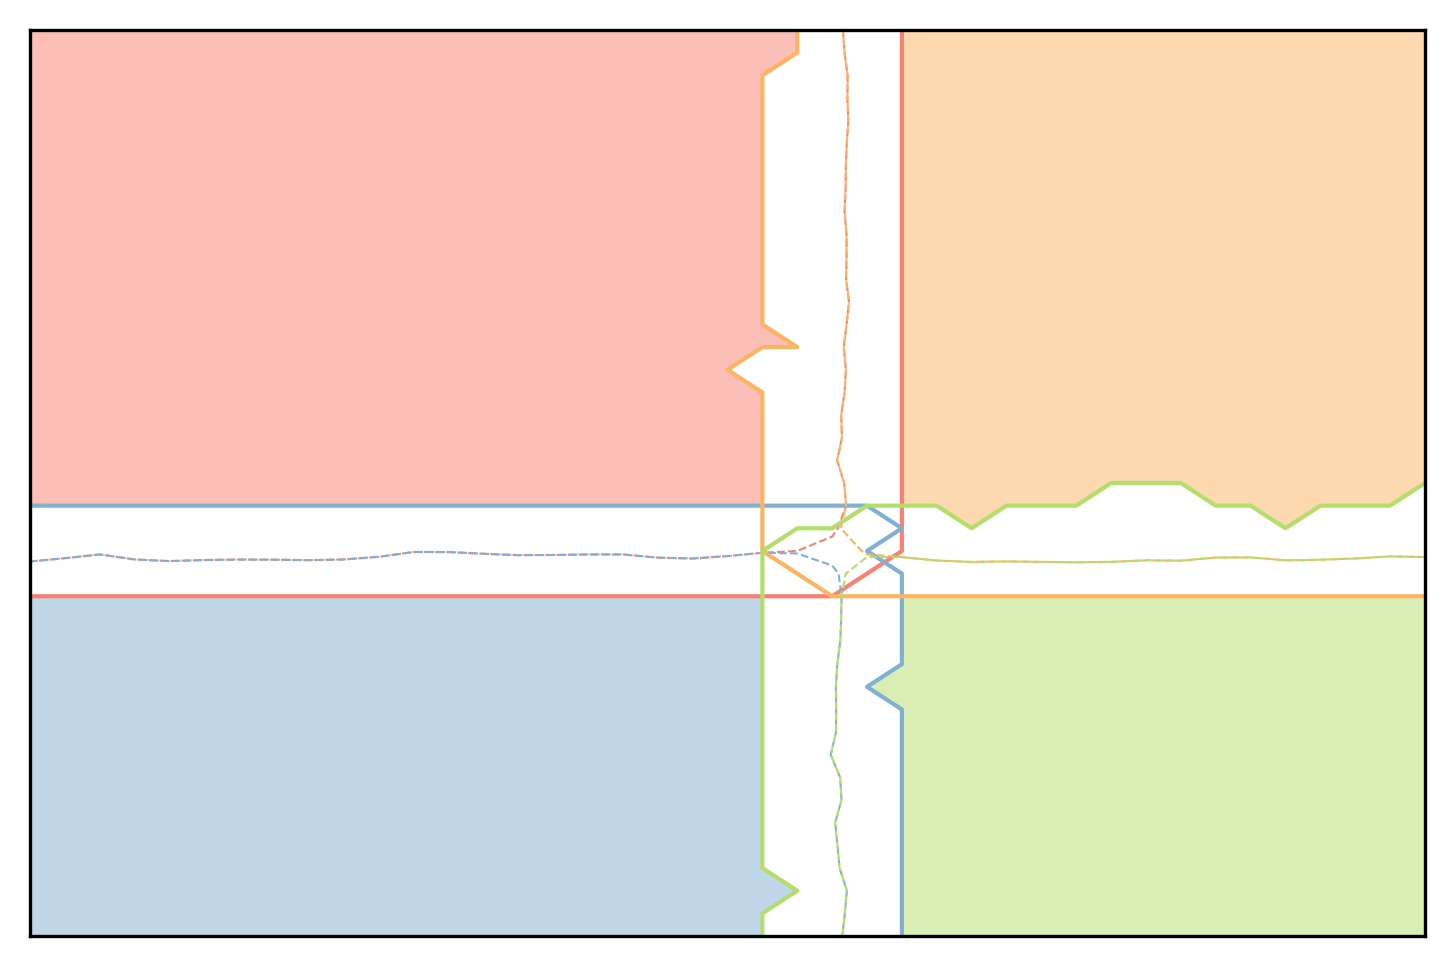

In [24]:
plt.figure(dpi=300)
for i, color in zip(range(num_partitions), ccycle):
    my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
    plt.contourf(colored_images[i][:,:, 3], levels=[0.99999, 1], colors=my_color, alpha=0.5)
    plt.contour(colored_images[i][:,:, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[1, 0.5, 1.0], linestyles=['solid','dashed','solid'])

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
_ = ax.set_ylim(40, 0)

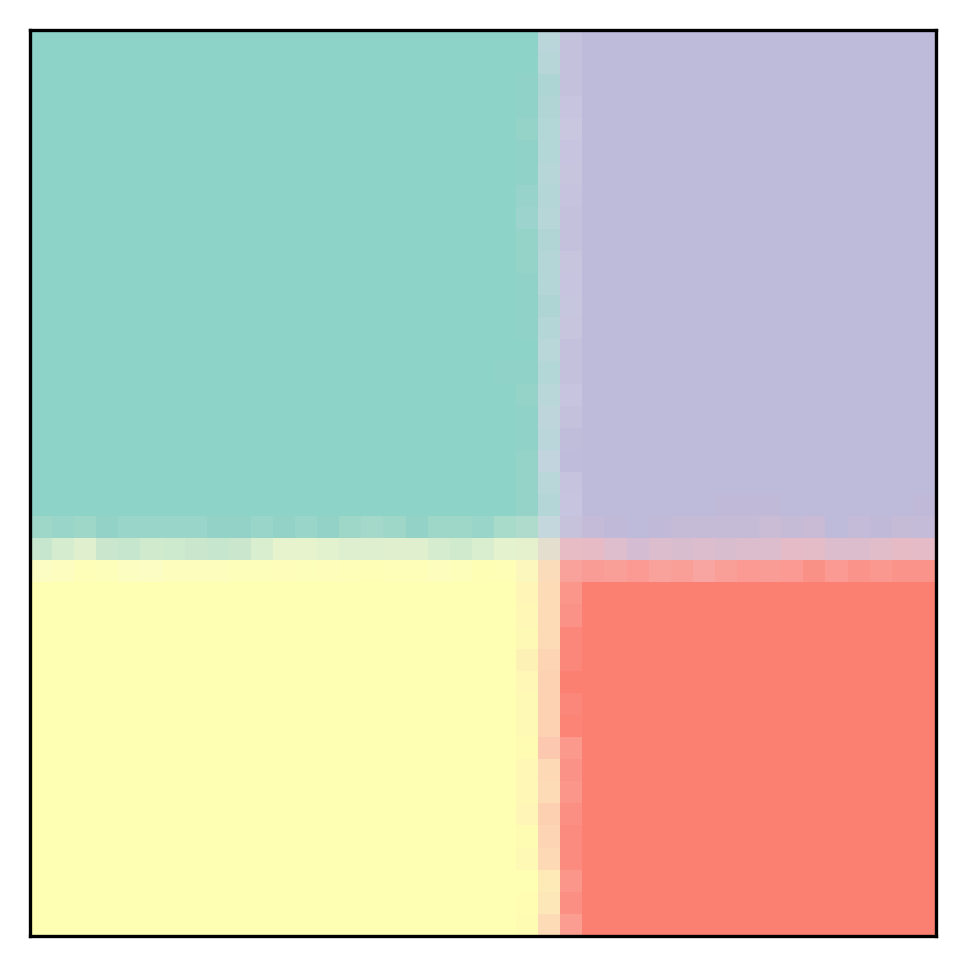

In [25]:
composite_image = 255*np.ones(colored_images[0].shape)[:,:,:-1]
for colored_image in colored_images:
    composite_image = overlay_alpha_image_precise(composite_image, 255*colored_image, 1.)
plt.figure(dpi=300)
plt.imshow(composite_image)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.savefig("{}/composite_probabilities.png".format(my_dir), bbox_inches='tight')

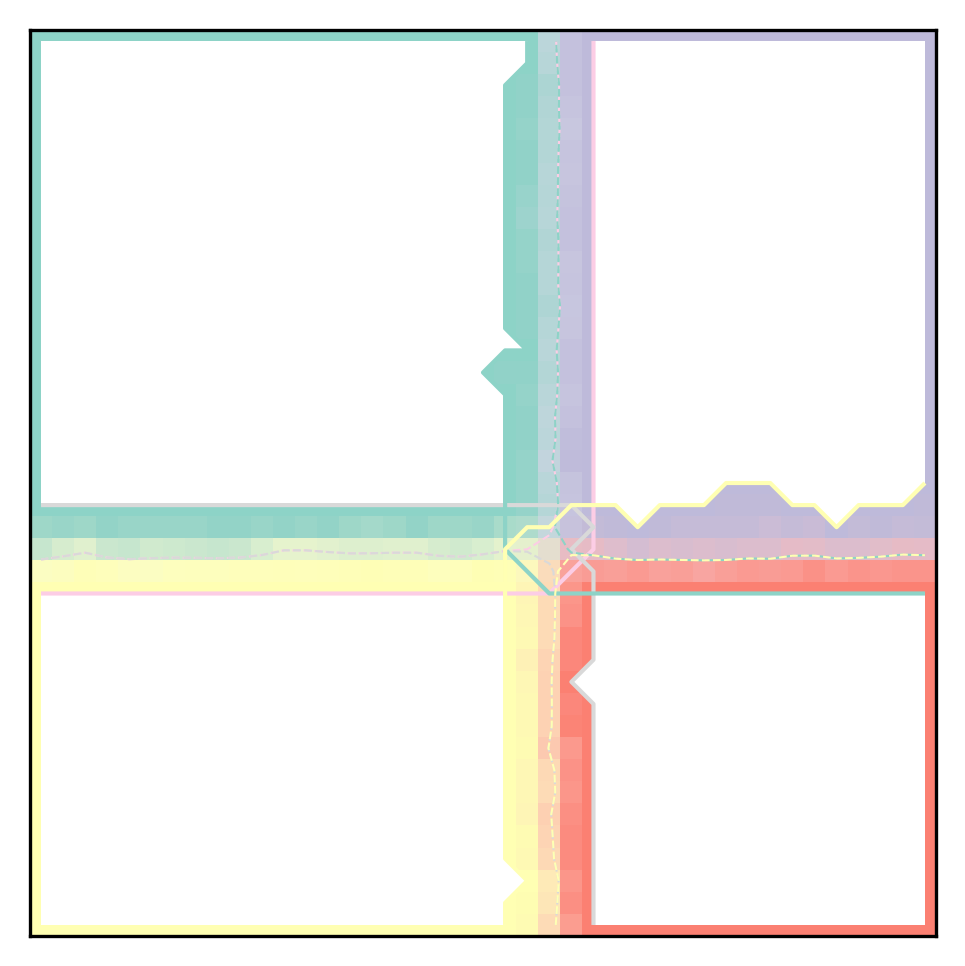

In [26]:
composite_image = 255*np.ones(colored_images[0].shape)[:,:,:-1]
for colored_image in colored_images:
    composite_image = overlay_alpha_image_precise(composite_image, 255*colored_image, 1.)
plt.figure(dpi=300)
for i, color in zip(range(num_partitions), ccycle):
    my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
    plt.contourf(colored_images[i][:,:, 3], levels=[0.99999, 1], colors="#FFFFFF", alpha=1)
    plt.contour(colored_images[i][:,:, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[1, 0.5, 1.0], linestyles=['solid','dashed','solid'])

plt.imshow(composite_image)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.savefig("{}/composite_probabilities.png".format(my_dir), bbox_inches='tight')

In [27]:
# plot_realization(ground_truth)
# ax = plt.gca()

# ax.axvline(23.5, 0, 41, c="#ffffff")
# ax.axhline(23.5, 0, 41, c="#ffffff")

# ax.axvline(31.5, 0, 41, c="#ffffff")
# ax.axhline(31.5, 0, 41, c="#ffffff")
# ax.axvline(8.5, 0, 41, c="#ffffff")
# ax.axhline(8.5, 0, 41, c="#ffffff")
# x = np.arange(0,41)
# y1 = x-23
# plt.plot(x, y1, c="#ffffff")
# y2 = 17-x
# plt.plot(x, y2, c="#ffffff")
# y3 = 63-x
# plt.plot(x, y3, c="#ffffff")
# y4 = x+23
# plt.plot(x, y4, c="#ffffff")
# plt.gca().set_xlim(0,41)
# plt.gca().set_ylim(0,41)

In [28]:
plt.figure(dpi=800)

all_ps = []
all_counts = []
for i in range(uncertain_realizations.shape[2]):
    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')

    X, Y = massage_data(uncertain_realizations[:, :, i])
    tmc.build(X, Y)
    ps = [0]

    count = len(np.unique(list(tmc.get_partitions(0).keys())))
    counts = [count]
    eps = 1e-6
    for i, p in enumerate(tmc.persistences):
        ps.append(p)
        counts.append(count)
        count = len(np.unique(list(tmc.get_partitions(p+eps).keys())))
        ps.append(p)
        counts.append(count)

    all_ps.append(ps)
    all_counts.append(counts)
    plt.plot(ps, counts, alpha=0.2, c='#1f78b4')

ax = plt.gca()
ax.set_ylim(0, 25)
# plt.axhline(2, 0.10, 0.20, linestyle='dashed', color='#000000')
plt.show()
plt.savefig("{}/composite_persistence_charts.png".format(my_dir), bbox_inches='tight')

TypeError: 'module' object is not callable

<Figure size 4800x3200 with 0 Axes>

In [ ]:
# plt.figure(dpi=800)

# for i in range(uncertain_realizations.shape[2]):
#     graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
#     tmc = topopy.MorseComplex(graph=graph,
#                               gradient='steepest',
#                               normalization='feature')

#     X, Y = massage_data(uncertain_realizations[:, :, i])
#     tmc.build(X, Y)
#     ps = [0]
#     eps = 1e-6
#     delta_ps = []
#     for i, p in enumerate(tmc.persistences):
#         if i > 0:
#             delta_ps.append(p - tmc.persistences[i-1])
#     plt.plot(delta_ps, alpha=0.2, c='#1f78b4')

# plt.axhline(0.10*(np.max(Y)-np.min(Y)), 0, np.max(Y), linestyle='dashed', color='#000000')
# ax = plt.gca()
# # ax.set_ylim(0, 25)
# plt.show()

In [ ]:
max_points = set()

for i in range(uncertain_realizations.shape[2]):
    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')

    X, Y = massage_data(uncertain_realizations[:, :, i])
    tmc.build(X, Y)

    for key in tmc.get_partitions(0.5).keys():
        max_points.add((int(X[key, 0]), int(X[key, 1])))

In [ ]:
plt.figure(dpi=800)
maxima = np.array(list(max_points))
maxima = MinMaxScaler().fit_transform(maxima)
# clustering = DBSCAN(eps=0.3, min_samples=3).fit(maxima)
clustering = sklearn.cluster.SpectralClustering(n_clusters=9).fit(maxima)
unique_labels = np.unique(clustering.labels_)

colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]
    
ccycle = cycle(colorList)

color_map = {}
for label in unique_labels:
    color_map[label] = next(ccycle)

my_colors = []
for i in range(len(maxima)):
    my_colors.append(color_map[clustering.labels_[i]])
plt.scatter(maxima[:,0], maxima[:,1], c=colors)

# Precipitation Ensemble

In [ ]:
from mpl_toolkits.basemap import Basemap
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

In [ ]:
def plot_map_realization(latlon, grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')
    tmc.build(X, Y)

    partitions = tmc.get_partitions(0.1)
    keys = partitions.keys()

    keyMap = {}
    for i,k in enumerate(keys):
        keyMap[k] = i

    colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]
    
    ccycle = cycle(colorList)

    uniqueCount = len(keys)
    usedColors = []
    for i,c in zip(range(uniqueCount), ccycle):
        usedColors.append(c)
    cmap = colors.ListedColormap(usedColors)
    bounds = np.array([keyMap[k] for k in keys]) - 0.5
    bounds = bounds.tolist()
    bounds.append(bounds[-1]+1)
    plt.figure(dpi=800)

    color_mesh = np.zeros((w, h))
    for key, indices in partitions.items():
        for idx in indices:
            color_mesh[idx // w, idx % w] = keyMap[key]

    fig = plt.figure(figsize=(8, 8), edgecolor='w')
    min_latitude = -10
    max_latitude = 90
    min_longitude = 0
    max_longitude = 100
    bmap = Basemap(projection='cyl',
                llcrnrlat=np.min(latlon[:,:,0]), urcrnrlat=np.max(latlon[:,:,0]),
                llcrnrlon=np.min(latlon[:,:,1]), urcrnrlon=np.max(latlon[:,:,1]), )
    draw_map(bmap)
    bmap.drawcoastlines(linewidth=0.25)
    bmap.drawcountries(linewidth=0.25)            
    img = bmap.imshow(color_mesh.T, cmap=cmap, interpolation="nearest", origin="lower", alpha=0.25)
    plt.colorbar(img, cmap=cmap, ticks=[range(uniqueCount)], boundaries=bounds)
    bmap.contour(latlon[:,:,1], latlon[:,:,0], grid, cmap=cm.Greys, latlon=True)

In [ ]:
uncertain_realizations = np.load("precipitation_2019-02-08T00:00:00.npy")
latlon = np.load("latlon_2019-02-08T00:00:00.npy")
mean_realization = np.mean(uncertain_realizations, axis=2)

my_dir = "precipitation_forecast"
if not os.path.exists(my_dir):
    os.makedirs(my_dir)

In [ ]:
fig = plt.figure(figsize=(8, 8), edgecolor='w')
bmap = Basemap(projection='cyl',
#             llcrnrlat=min_latitude, urcrnrlat=max_latitude,
#             llcrnrlon=min_longitude, urcrnrlon=max_longitude, )
            llcrnrlat=np.min(latlon[:,:,0]), urcrnrlat=np.max(latlon[:,:,0]),
            llcrnrlon=np.min(latlon[:,:,1]), urcrnrlon=np.max(latlon[:,:,1]), )
draw_map(bmap)
bmap.drawcoastlines(linewidth=0.25)
bmap.drawcountries(linewidth=0.25)
img = bmap.imshow(uncertain_realizations[:,:,0].T, interpolation="nearest", origin="lower", alpha=0.5)
contours = bmap.contour(latlon[:,:,1], latlon[:,:,0], uncertain_realizations[:,:,0], cmap=cm.Greys, latlon=True)
cb = plt.colorbar(img)
cb.add_lines(contours)

In [ ]:
plot_map_realization(latlon, uncertain_realizations[:,:,0])

## Visualize Realizations and Mean

In [ ]:
for i in range(uncertain_realizations.shape[2]):
    plot_map_realization(latlon, uncertain_realizations[:,:,i])
    plt.savefig("{}/realization_{}.png".format(my_dir, i), bbox_inches='tight')

In [ ]:
plot_map_realization(latlon, mean_realization)
plt.savefig("{}/realization_mean.png".format(my_dir), bbox_inches='tight')

## Determine Survival Count to see if there are Clear Uncertain Regions

In [ ]:
all_counts = np.zeros(uncertain_realizations[:,:,0].shape)
all_weighted_counts = np.zeros(uncertain_realizations[:,:,0].shape)
for i in range(uncertain_realizations.shape[2]):
# for i in range(1):
    counts, weighted_counts = count_persistence(uncertain_realizations[:,:,i])
    all_counts += counts
    all_weighted_counts += weighted_counts

In [ ]:
fig = plt.figure(figsize=(8, 8), edgecolor='w')
m = Basemap(projection='cyl',
            llcrnrlat=np.min(latlon[:,:,0]), urcrnrlat=np.max(latlon[:,:,0]),
            llcrnrlon=np.min(latlon[:,:,1]), urcrnrlon=np.max(latlon[:,:,1]), )
draw_map(m)
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

img = m.imshow(all_counts.T, cmap=cm.Greys, alpha=0.25)
plt.colorbar(img)
k = (np.max(all_counts) + np.min(all_counts)) / 2.
print(k)
bmap.contour(latlon[:,:,1], latlon[:,:,0], all_counts, levels=[k], colors='#FFFF00', latlon=True)
plt.savefig("{}/survival_count.png".format(my_dir), bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 8), edgecolor='w')
m = Basemap(projection='cyl',
            llcrnrlat=np.min(latlon[:,:,0]), urcrnrlat=np.max(latlon[:,:,0]),
            llcrnrlon=np.min(latlon[:,:,1]), urcrnrlon=np.max(latlon[:,:,1]), )
draw_map(m)
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
img2 = m.imshow(all_weighted_counts.T, cmap=cm.Greys)
plt.colorbar(img2)
k = (np.max(all_weighted_counts) + np.min(all_weighted_counts)) / 2.
print(k)
bmap.contour(latlon[:,:,1], latlon[:,:,0], all_weighted_counts, levels=[k], colors='#FFFF00', latlon=True)
plt.savefig("{}/weighted_survival_count.png".format(my_dir), bbox_inches='tight')

## Look at the variance of the weighted count to highlight highly varying regions

In [ ]:
mean_images = []
max_radius = 5

image = (all_weighted_counts - np.min(all_weighted_counts)) / (np.max(all_weighted_counts) - np.min(all_weighted_counts))
eps=1e-16
for i in range(1, max_radius):
    mean_images.append(filters.rank.mean(image, selem=morphology.disk(i)))

image = 255*image
variance_images = []
eps=1e-16
for i, mean_image in enumerate(mean_images):
    variance_images.append(np.power(image-mean_image,2)+eps)
    show_image(variance_images[-1].T)
    plt.gca().set_title("Variance r={}".format(i))

plt.savefig("{}/weighted_surival_count_variance.png".format(my_dir), bbox_inches='tight')

## Does the Persistence Chart tell us anything?

In [ ]:
plt.figure(dpi=800)

for i in range(uncertain_realizations.shape[2]):
    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')

    X, Y = massage_data(uncertain_realizations[:, :, i])
    tmc.build(X, Y)
    ps = [0]

    count = len(np.unique(list(tmc.get_partitions(0).keys())))
    counts = [count]
    eps = 1e-6
    for i, p in enumerate(tmc.persistences):
        ps.append(p)
        counts.append(count)
        count = len(np.unique(list(tmc.get_partitions(p+eps).keys())))
        ps.append(p)
        counts.append(count)
    plt.plot(ps, counts, alpha=0.2, c='#1f78b4')

ax = plt.gca()
ax.set_ylim(0, 50)
# plt.axhline(2, 0.10, 0.20, linestyle='dashed', color='#000000')
plt.show()
plt.savefig("{}/composite_persistence_charts.png".format(my_dir), bbox_inches='tight')

## Set n_clusters based on above analysis and try to cluster the data

In [ ]:
max_points = list()
max_member = list()

for i in range(uncertain_realizations.shape[2]):
    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')

    X, Y = massage_data(uncertain_realizations[:, :, i])
    tmc.build(X, Y)

    for key in tmc.get_partitions(20).keys():
        max_points.append((int(X[key, 0]), int(X[key, 1])))
        max_member.append(i)

In [ ]:
plt.figure(dpi=800)
maxima = np.array(max_points)
maxima = MinMaxScaler().fit_transform(maxima)
clustering = sklearn.cluster.MeanShift().fit(maxima)
clustering = sklearn.cluster.MiniBatchKMeans(n_clusters=7).fit(maxima)
# clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=6).fit(maxima)
# clustering = sklearn.cluster.KMeans(n_clusters=6).fit(maxima)
# clustering = sklearn.cluster.DBSCAN(eps=0.3, min_samples=3).fit(maxima)
# clustering = sklearn.cluster.SpectralClustering(n_clusters=6).fit(maxima)
unique_labels = np.unique(clustering.labels_)
maxima_map = {}
colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]
    
ccycle = cycle(colorList)

color_map = {}
for label in unique_labels:
    color_map[label] = next(ccycle)

my_colors = []
for i in range(len(maxima)):
    my_colors.append(color_map[clustering.labels_[i]])
    maxima_map[max_points[i]] = clustering.labels_[i]
    r = 0.025
    x = r*np.cos(max_member[i]/uncertain_realizations.shape[2]*2*np.pi)
    y = r*np.sin(max_member[i]/uncertain_realizations.shape[2]*2*np.pi)
    eps = np.array([x-0.01, y-0.02])
    plt.annotate("{}".format(max_member[i]), maxima[i,:]+eps)
_ = plt.scatter(maxima[:,0], maxima[:,1], c=my_colors)

In [ ]:
def assignments(grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')
    tmc.build(X, Y)

    correct_p = 20
    partitions = tmc.get_partitions(p)
            
    field = np.zeros(Y.shape, dtype=int)
    for k, v in partitions.items():
        field[v] = maxima_map[(int(X[k, 0]), int(X[k, 1]))]

    
    return field.reshape(grid.shape), correct_p

In [ ]:
ps = []
fields = []
for i in range(uncertain_realizations.shape[2]):
    field, p = assignments(uncertain_realizations[:,:,i])
    ps.append(p)
    fields.append(field)
    
ps = np.array(ps)
fields = np.array(fields)
print(np.min(ps), np.max(ps), np.mean(ps), np.std(ps))

## Look at the probabilities of each pixel flowing to the local maxima clusters

In [ ]:
num_partitions = len(np.unique(fields[0]))
shape = (num_partitions,) + fields[0].shape
label_images = np.zeros(shape)

dim1 = int(np.ceil(np.sqrt(num_partitions)))
dim2 = int(np.floor(num_partitions/dim1+0.5))
fig, axes = plt.subplots(dim1, dim2, tight_layout=True)

axes = axes.flatten()

for i in range(num_partitions):
    test_image = (fields == i)
    label_images[i] = np.sum(test_image, axis=0)
    img = axes[i].imshow(label_images[i])
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
for i in range(num_partitions, dim1*dim2):
    axes[i].set_visible(False)

plt.savefig("{}/partition_probabilities.png".format(my_dir), bbox_inches='tight')

# fig.colorbar(img, ax=axes.ravel().tolist())

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(img, cax=cbar_ax)

## Color Blended Example

In [ ]:
color_list = [[141,211,199], [255,255,179], [190,186,218],
              [251,128,114], [128,177,211], [253,180,98],
              [179,222,105], [252,205,229], [217,217,217]]
# color_list = [[105,239,123], [149,56,144], [192,222,164],
#                 [14,80,62], [153,222,249], [24,81,155],
#                 [218,185,255], [66,30,200], [183,211,33]]
# color_list = [[251,180,174],[179,205,227],[204,235,197],
#               [222,203,228],[254,217,166],[255,255,204],
#               [229,216,189],[253,218,236],[242,242,242]]

ccycle = cycle(color_list)

colored_images = []
for i, c in zip(range(num_partitions), ccycle):
    colored_image = np.zeros(label_images[0].shape + (4,))
    colored_image[:,:,0] = c[0]/255.
    colored_image[:,:,1] = c[1]/255.
    colored_image[:,:,2] = c[2]/255.
    colored_images.append(colored_image)

for i, label_image in enumerate(label_images):
    colored_images[i][:,:, 3] = label_image / uncertain_realizations.shape[2]

for i in range(num_partitions):
    plt.figure()
    plt.imshow(colored_images[i])

In [ ]:
composite_image = 255*np.ones(colored_images[0].shape)[:,:,:-1]
for colored_image in colored_images:
    composite_image = overlay_alpha_image_precise(composite_image, 255*colored_image, 1.)
plt.figure(dpi=300)
plt.imshow(composite_image)
plt.savefig("{}/composite_probabilities.png".format(my_dir), bbox_inches='tight')

## Lastly, try overlaying contours

In [ ]:
for i, color in zip(range(num_partitions), ccycle):
    my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
    plt.figure(dpi=100)
    plt.contourf(colored_images[i][:,:, 3].T, levels=[0.05, 1.0], colors=my_color, alpha=0.5)
    plt.contour(colored_images[i][:,:, 3].T, levels=[0.05, 0.2, 0.4, 0.6, 0.8, 0.98], colors=my_color, linewidths=[1, 0.5, 0.5, 0.5, 0.5, 0.5], linestyles=['solid','dashed','dashed','dashed','dashed','dashed'])
    plt.gca().set_ylim(colored_images[i].shape[1], 0)

In [ ]:
plt.figure(dpi=300)
for i, color in zip(range(num_partitions), ccycle):
    my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
    plt.contourf(colored_images[i][:,:, 3], levels=[1e-6, 1], colors=my_color, alpha=0.5)
    plt.contour(colored_images[i][:,:, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[1, 0.5, 1.0], linestyles=['solid','dashed','solid'])
plt.gca().set_ylim(colored_images[i].shape[1], 0)
plt.figure(dpi=300)

In [ ]:
plt.figure(dpi=300)
for i, color in zip(range(num_partitions), ccycle):
    my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
    plt.contourf(colored_images[i][:,:, 3], levels=[0.99999, 1], colors=my_color, alpha=0.5)
    plt.contour(colored_images[i][:,:, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[1, 0.5, 1.0], linestyles=['solid','dashed','solid'])
_ = plt.gca().set_ylim(colored_images[i].shape[1], 0)